In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
import pdb
import json
from math import sqrt

In [2]:
file_csv = '/home/mmp/Downloads/SPTAN1_1_Compiled_ActivityScan.csv'

data_df = pd.read_csv(file_csv)


In [4]:
data_df

Run_ID  DIV                  Time  Chip_ID  Well  NeuronType   
0         1    6  25-Jul-2023 10:17:28    16744     1   WT cortex  \
1         3    6  25-Jul-2023 10:33:20    16795     1   WT cortex   
2         5    6  25-Jul-2023 10:54:18    16855     1   WT cortex   
3         7    6  25-Jul-2023 11:14:01    16793     1   WT cortex   
4         9    6  25-Jul-2023 11:27:26    16854     1   WT cortex   
..      ...  ...                   ...      ...   ...         ...   
131     422   30  18-Aug-2023 15:31:36    16715     1  HET cortex   
132     426   30  18-Aug-2023 15:56:56    19337     1  HET cortex   
133     430   30  18-Aug-2023 16:24:08    19390     1  HET cortex   
134     434   30  18-Aug-2023 16:48:22    16719     1  HET cortex   
135     438   30  18-Aug-2023 17:13:07    16828     1  HET cortex   

     Active_Electrodes  Mean_FiringRate  Mean_SpikeAmplitude  
0                36.76         1.362529            45.273888  
1                31.18         1.281659            45.126900  
2                23.42         1.210268            44.067656  
3                18.77         0.908286            54.791423  
4                23.24         1.057003            49.015701  
..                 ...              ...                  ...  
131              97.23         4.467846            95.776265  
132              90.38         3.413356            95.809582  
133              71.59         3.343372            87.121124  
134              93.56         3.064794            99.651887  
135              91.30         4.195542            95.380022  

[136 rows x 9 columns]

In [5]:
df = data_df.replace(np.NaN,0.0)

In [6]:
div = df['DIV'].unique()
print(div)


[ 6  9 13 16 20 23 27 30]


In [6]:
div = [ 0 , 1  ,3 , 7 ,22 ,24, 27]

In [8]:
unique_genotypes = df['NeuronType'].unique()
unique_genotypes

array(['WT cortex', 'HET cortex'], dtype=object)

In [10]:
unique_therapy_types = df['Therapy_type'].unique()
unique_therapy_types

array(['CRISPRa', 'Control (GFP)', 'AAV'], dtype=object)

In [10]:
#unique_genotypes=['WT',  'HET']
#colors = ['lightsteelblue','cornflowerblue','royalblue','indianred','brown']
colors = ['royalblue','brown']

In [9]:
#unique_genotypes = [ 'ADNP2_WT2', 'ADNP3_WT','ADNP3_HET']
markers = ['o','s','d','*','^']

In [13]:
#Enter the  chip well ( key: vlaue) here to exclude.
exclude_dict = {'M07295':3}

if exclude_dict:
    # Using list comprehension for filtering
    print("hello")
    mask = [(row.Type=='xx')or(row.Type=='yy') or ((row.Chip_ID in exclude_dict) and (row.Well == exclude_dict[row.Chip_ID])) for index, row in df.iterrows()]

    df = df[~pd.Series(mask)]


hello


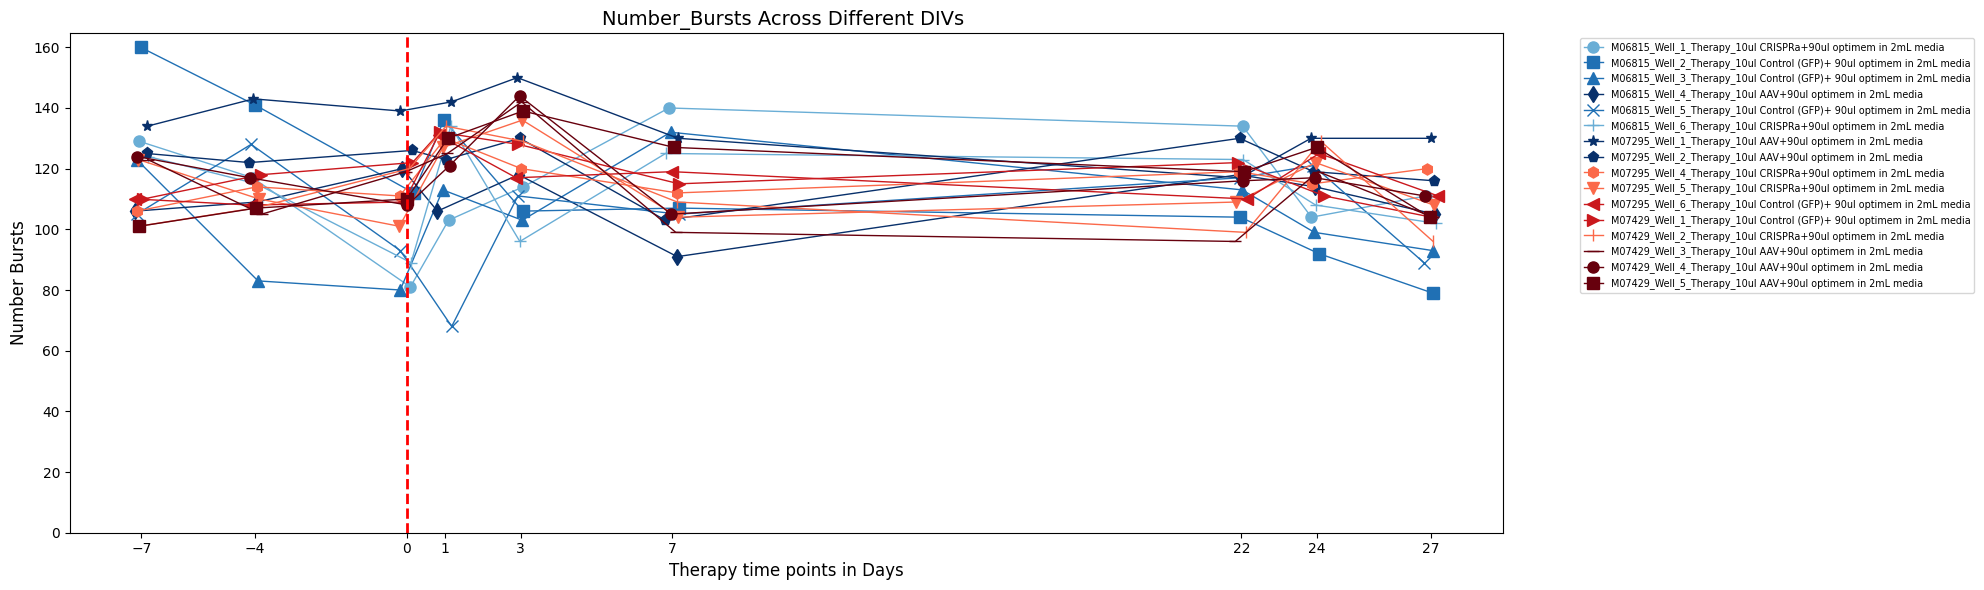

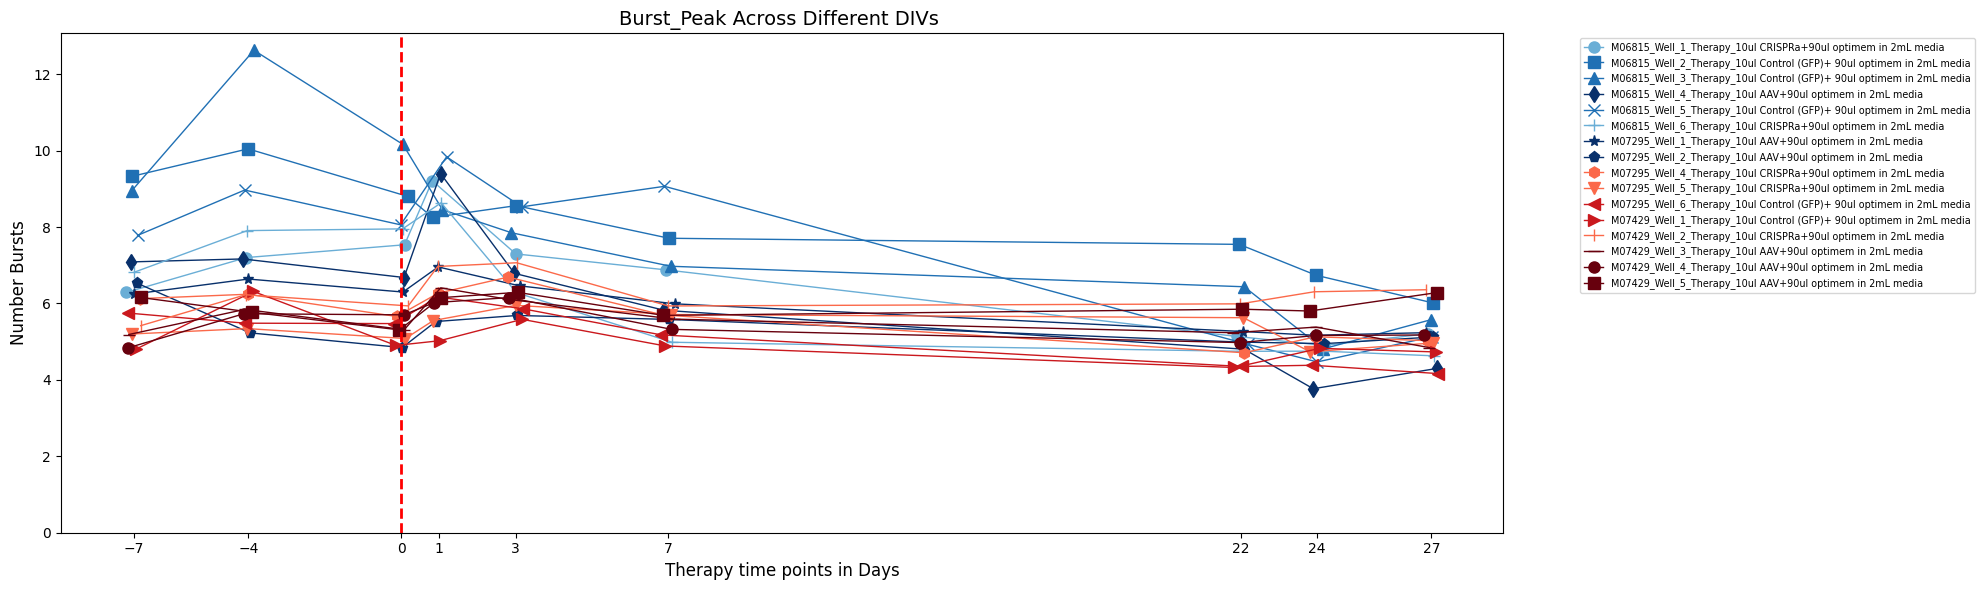

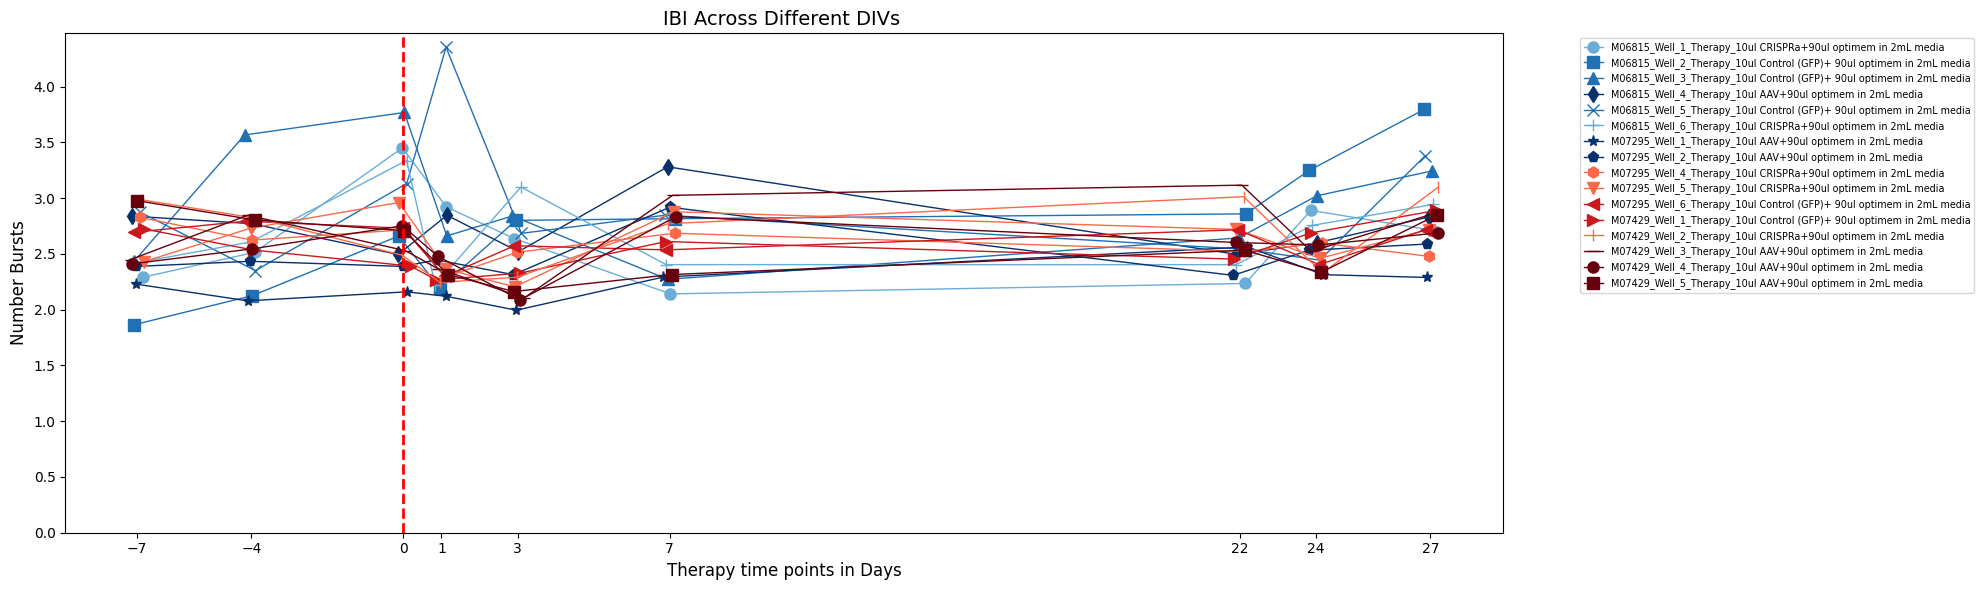

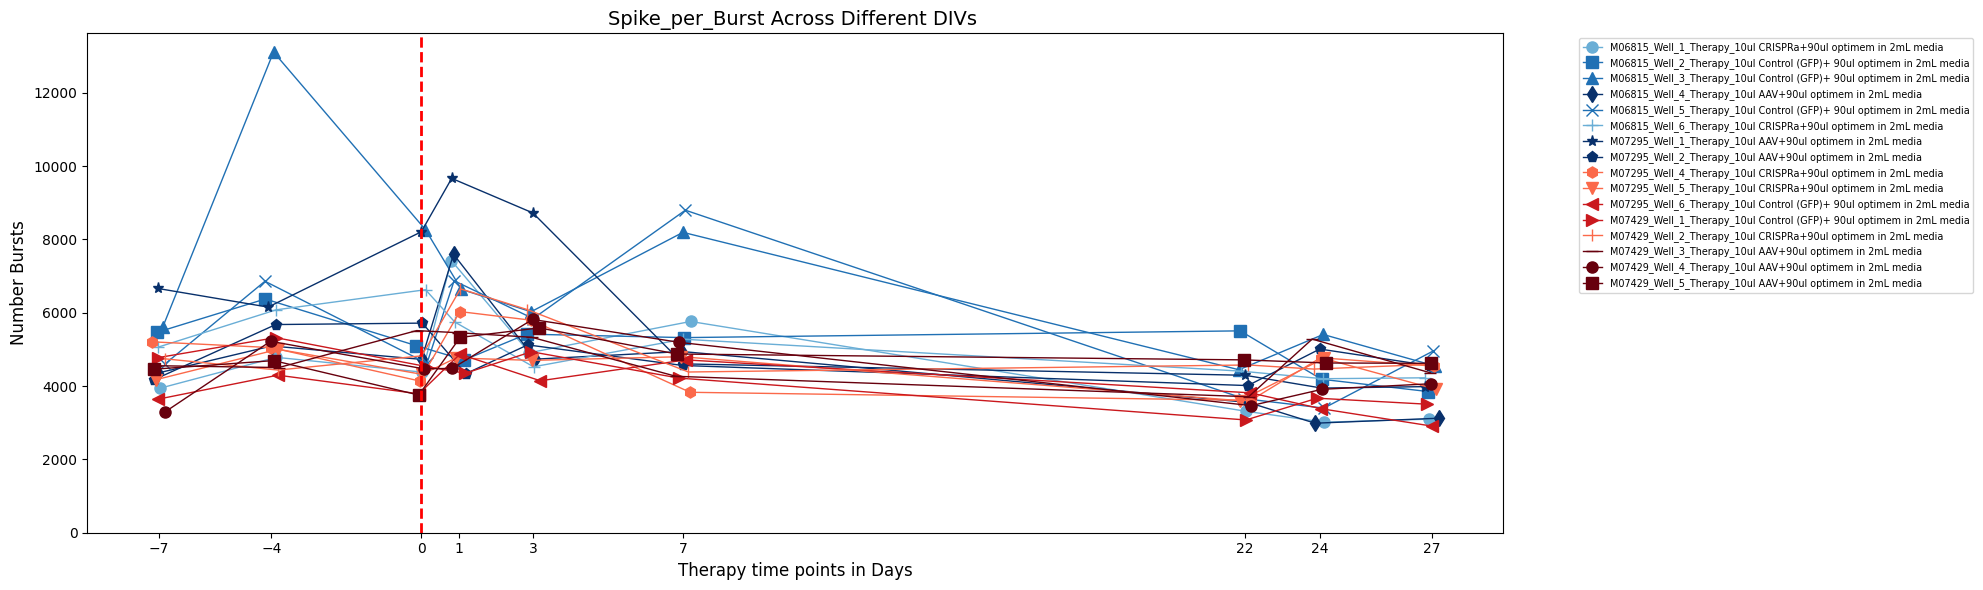

In [21]:
output_types = ["Number_Bursts","Burst_Peak","IBI","Spike_per_Burst"]

# Assuming 'df' is your DataFrame
for output_type in output_types:
    # Create a combined key for Chip_ID, Well, and Therapy_Type
    df['Chip_Well_Therapy_Key'] = df['Chip_ID'] + '_Well_' + df['Well'].astype(str) + '_Therapy_' + df['Therapy_type'].astype(str)

    # Generate unique keys for the color map based on Type and Therapy_Type
    unique_type_therapy_combinations = df[['Type', 'Therapy_type']].drop_duplicates()
    wt_combinations = unique_type_therapy_combinations[unique_type_therapy_combinations['Type'] == 'WT']
    het_combinations = unique_type_therapy_combinations[unique_type_therapy_combinations['Type'] == 'HET']

    # Define color maps for WT and HET types
    wt_colors = plt.cm.Blues(np.linspace(0.5, 1, len(wt_combinations)))
    het_colors = plt.cm.Reds(np.linspace(0.5, 1, len(het_combinations)))

    # Create color maps
    color_map = {}
    for (ttype, therapy), color in zip(wt_combinations.values, wt_colors):
        color_map[f'WT_{therapy}'] = color
    for (ttype, therapy), color in zip(het_combinations.values, het_colors):
        color_map[f'HET_{therapy}'] = color
    # Define a list of markers
    markers = ['o', 's', '^', 'd', 'x', '+', '*', 'p', 'h', 'v', '<', '>', '|', '_']

    # Ensure there are enough markers for each combination; if not, cycle through them
    if len(df['Chip_Well_Therapy_Key'].unique()) > len(markers):
        markers *= int(np.ceil(len(df['Chip_Well_Therapy_Key'].unique()) / len(markers)))

    # Assign a marker to each Chip_Well_Key
    marker_map = dict(zip(df['Chip_Well_Therapy_Key'].unique(), markers))
    def jitter(x, jitter_strength=0.1):
        return x + np.random.uniform(-jitter_strength, jitter_strength, size=np.shape(x))
    # Plotting with jitter and color coding based on Type and Therapy_Type
    fig, ax = plt.subplots(figsize=(20, 6))

    for combo in df['Chip_Well_Therapy_Key'].unique():
        combo_data = df[df['Chip_Well_Therapy_Key'] == combo]
        key_for_color = f"{combo_data['Type'].iloc[0]}_{combo_data['Therapy_type'].iloc[0]}"
        color = color_map[key_for_color]
        
        # Apply jitter
        jittered_DIV = jitter(combo_data['DIV'], jitter_strength=0.2)  # Adjust jitter strength as needed
        
        ax.plot(jittered_DIV, combo_data[output_type], label=f'{combo}',
                color=color, marker=marker_map[combo], linestyle='-', linewidth=1, markersize=8)

    ax.set_xticks(combo_data['DIV'])  # Set ticks at every available DIV position
    #ax.set_xticklabels(unique_divs)  # Label the ticks with the actual DIV values

    # Customizing the plot
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Therapy time points in Days', fontsize=12)
    ax.set_ylabel('Number Bursts', fontsize=12)
    ax.set_title(f'{output_type} Across Different DIVs ', fontsize=14)
    ax.axvline(x=0,color='r',linestyle='--',linewidth=2)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small', ncol=1)

    plt.tight_layout()
    plt.show()

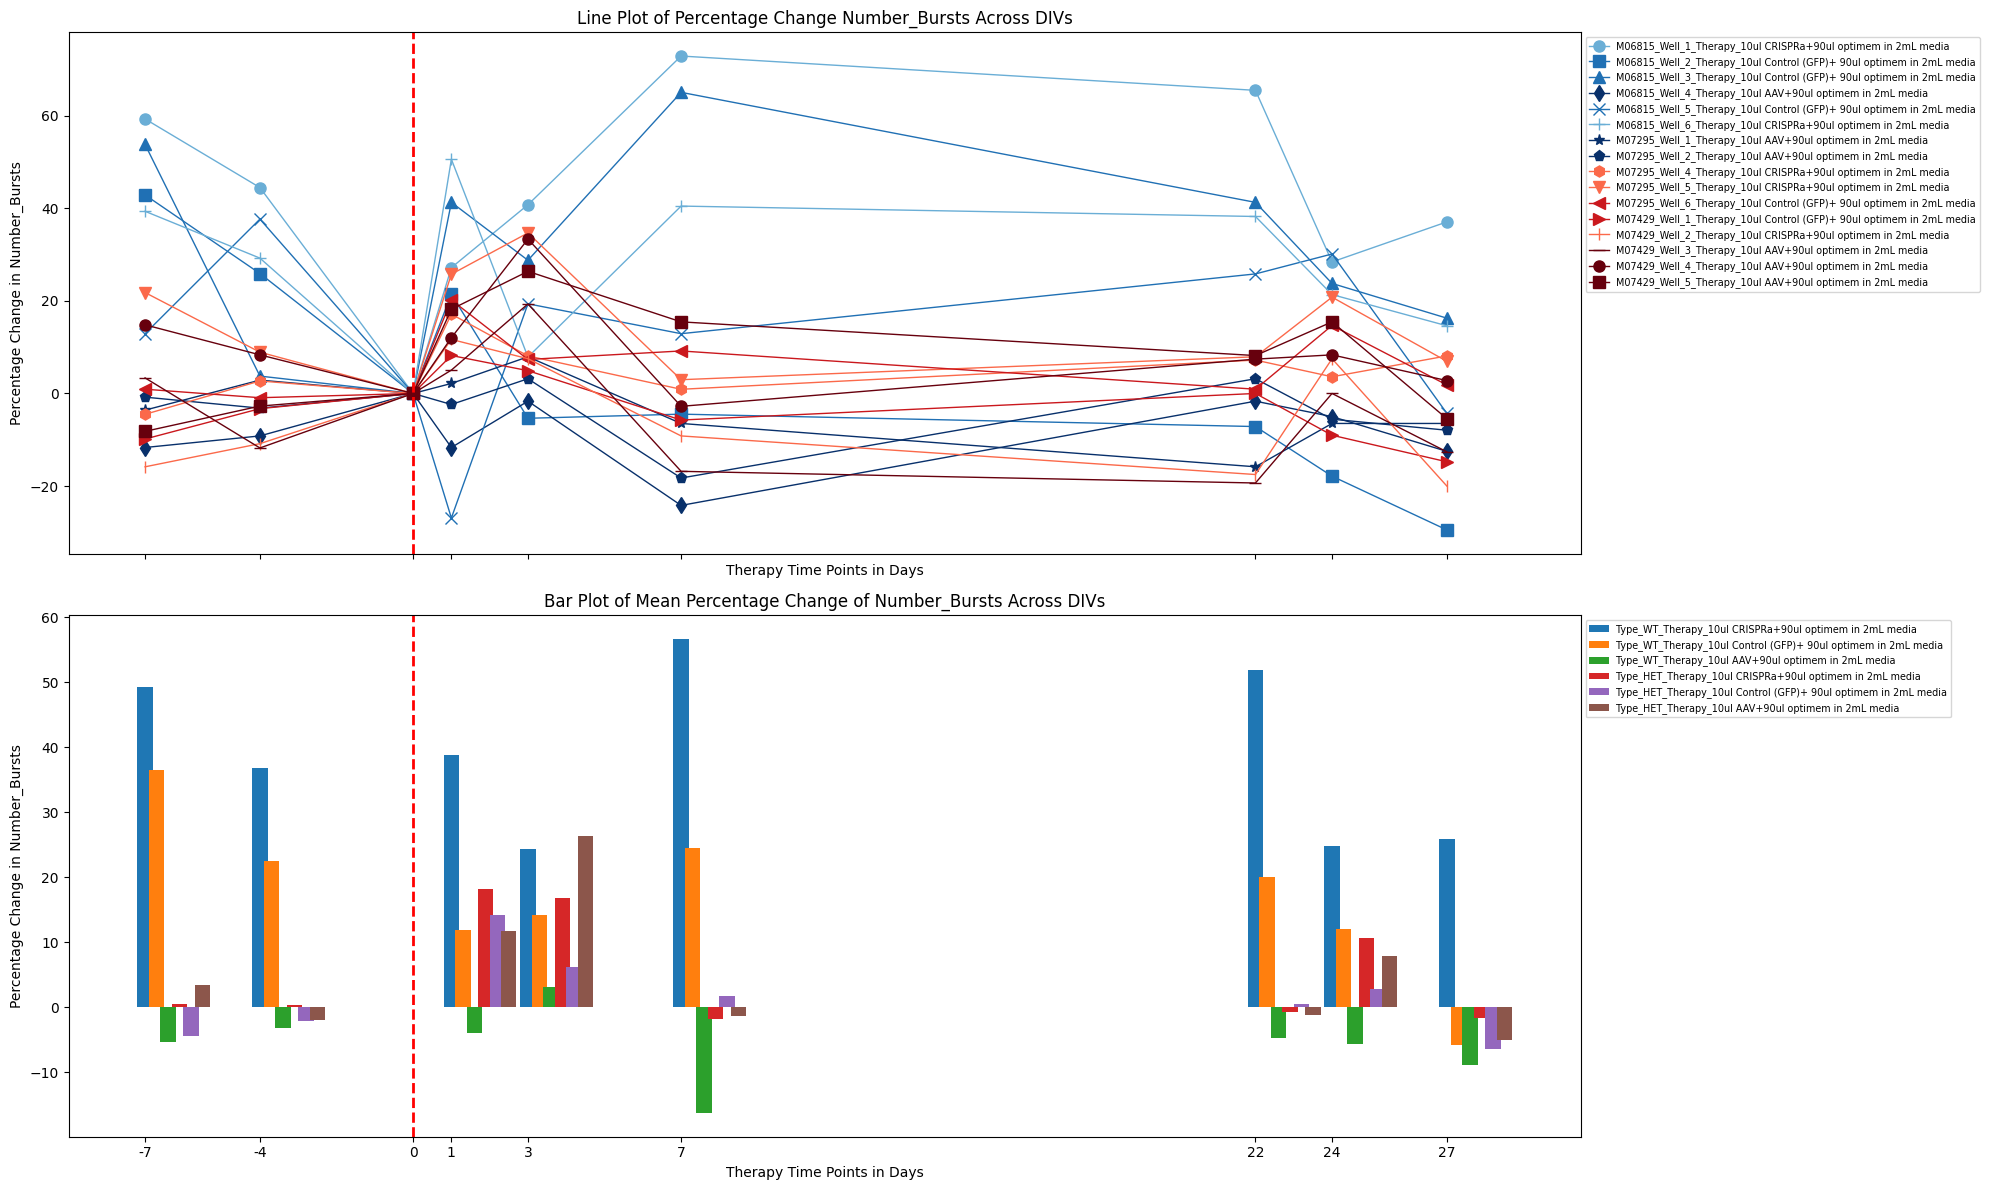

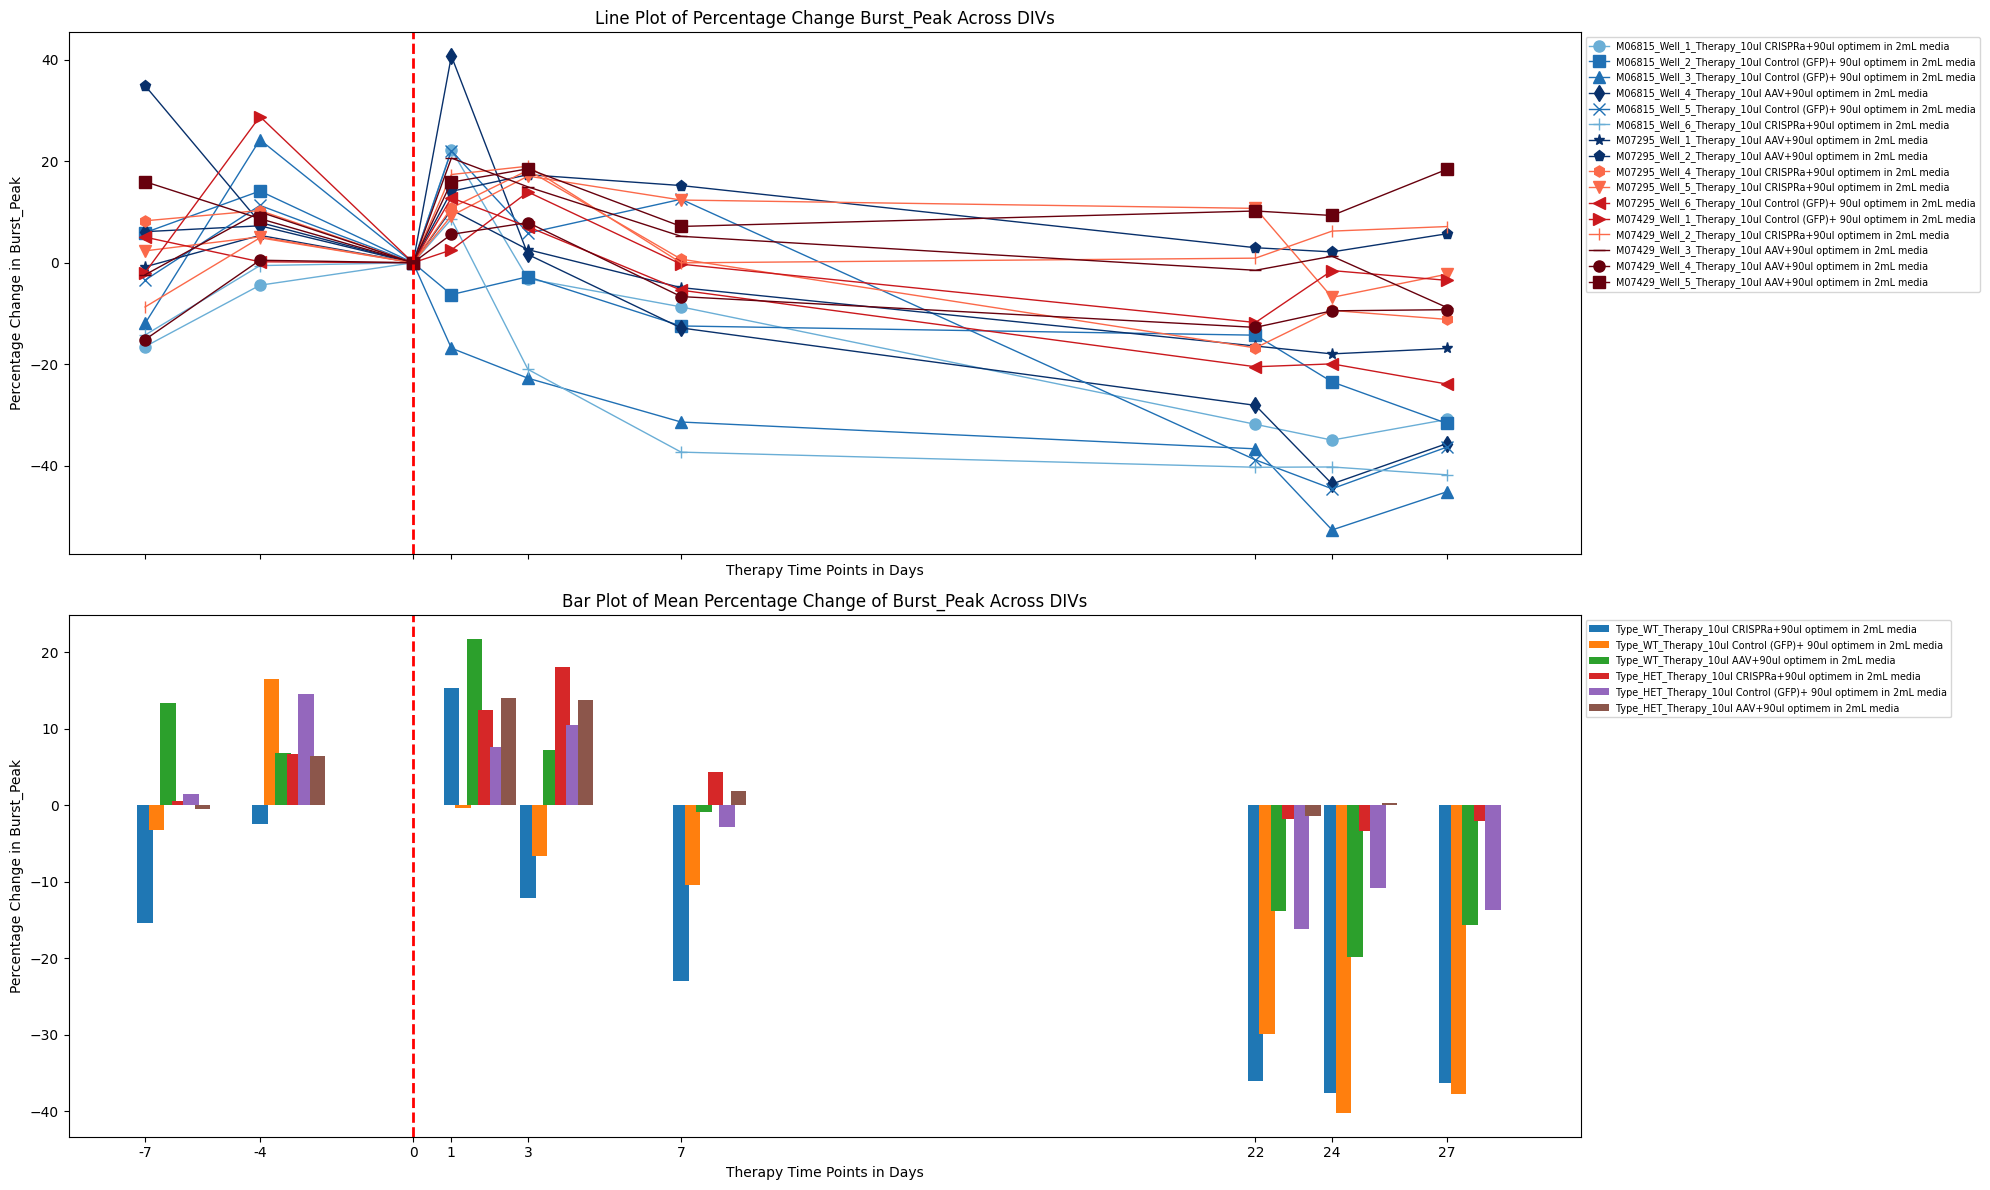

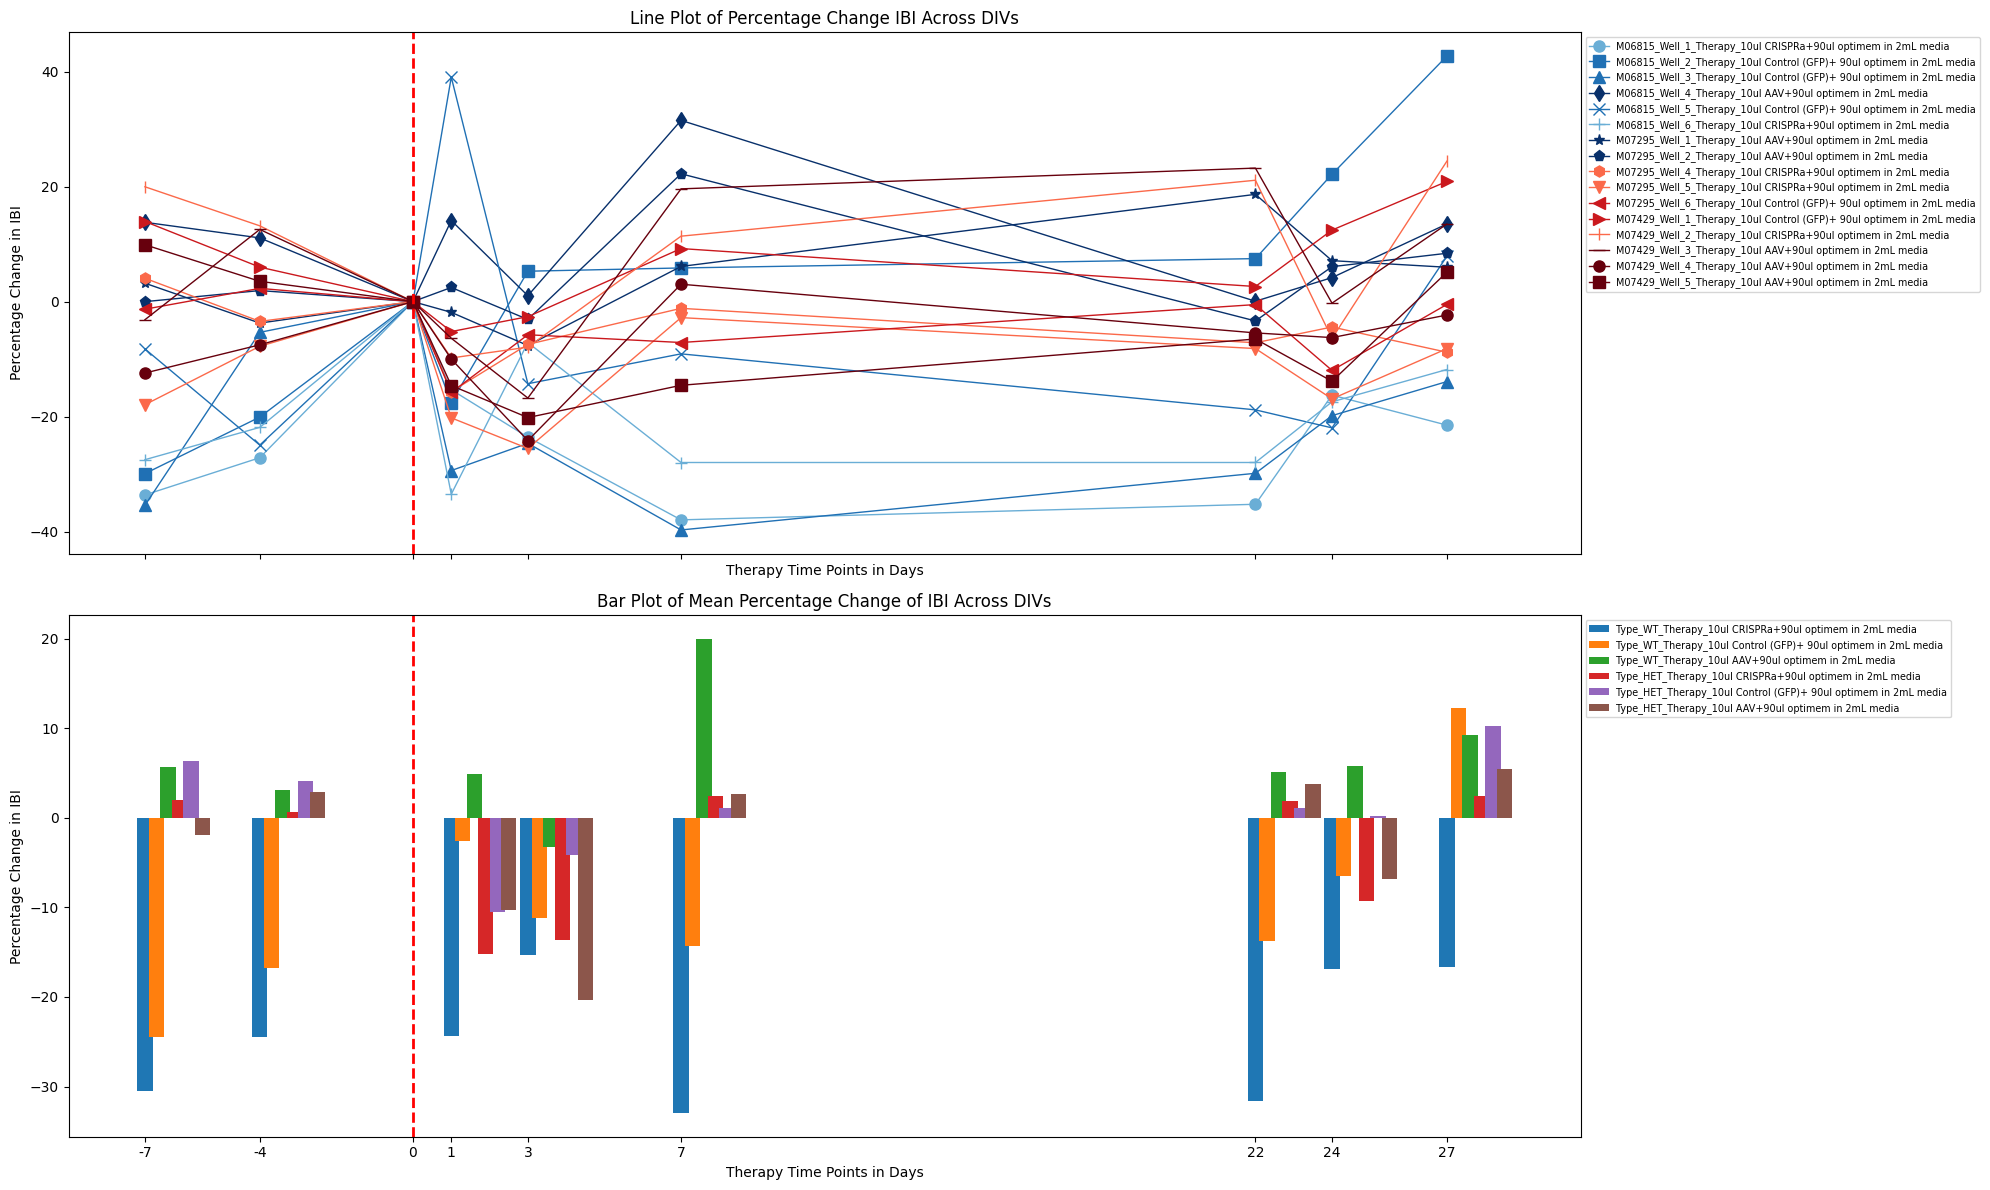

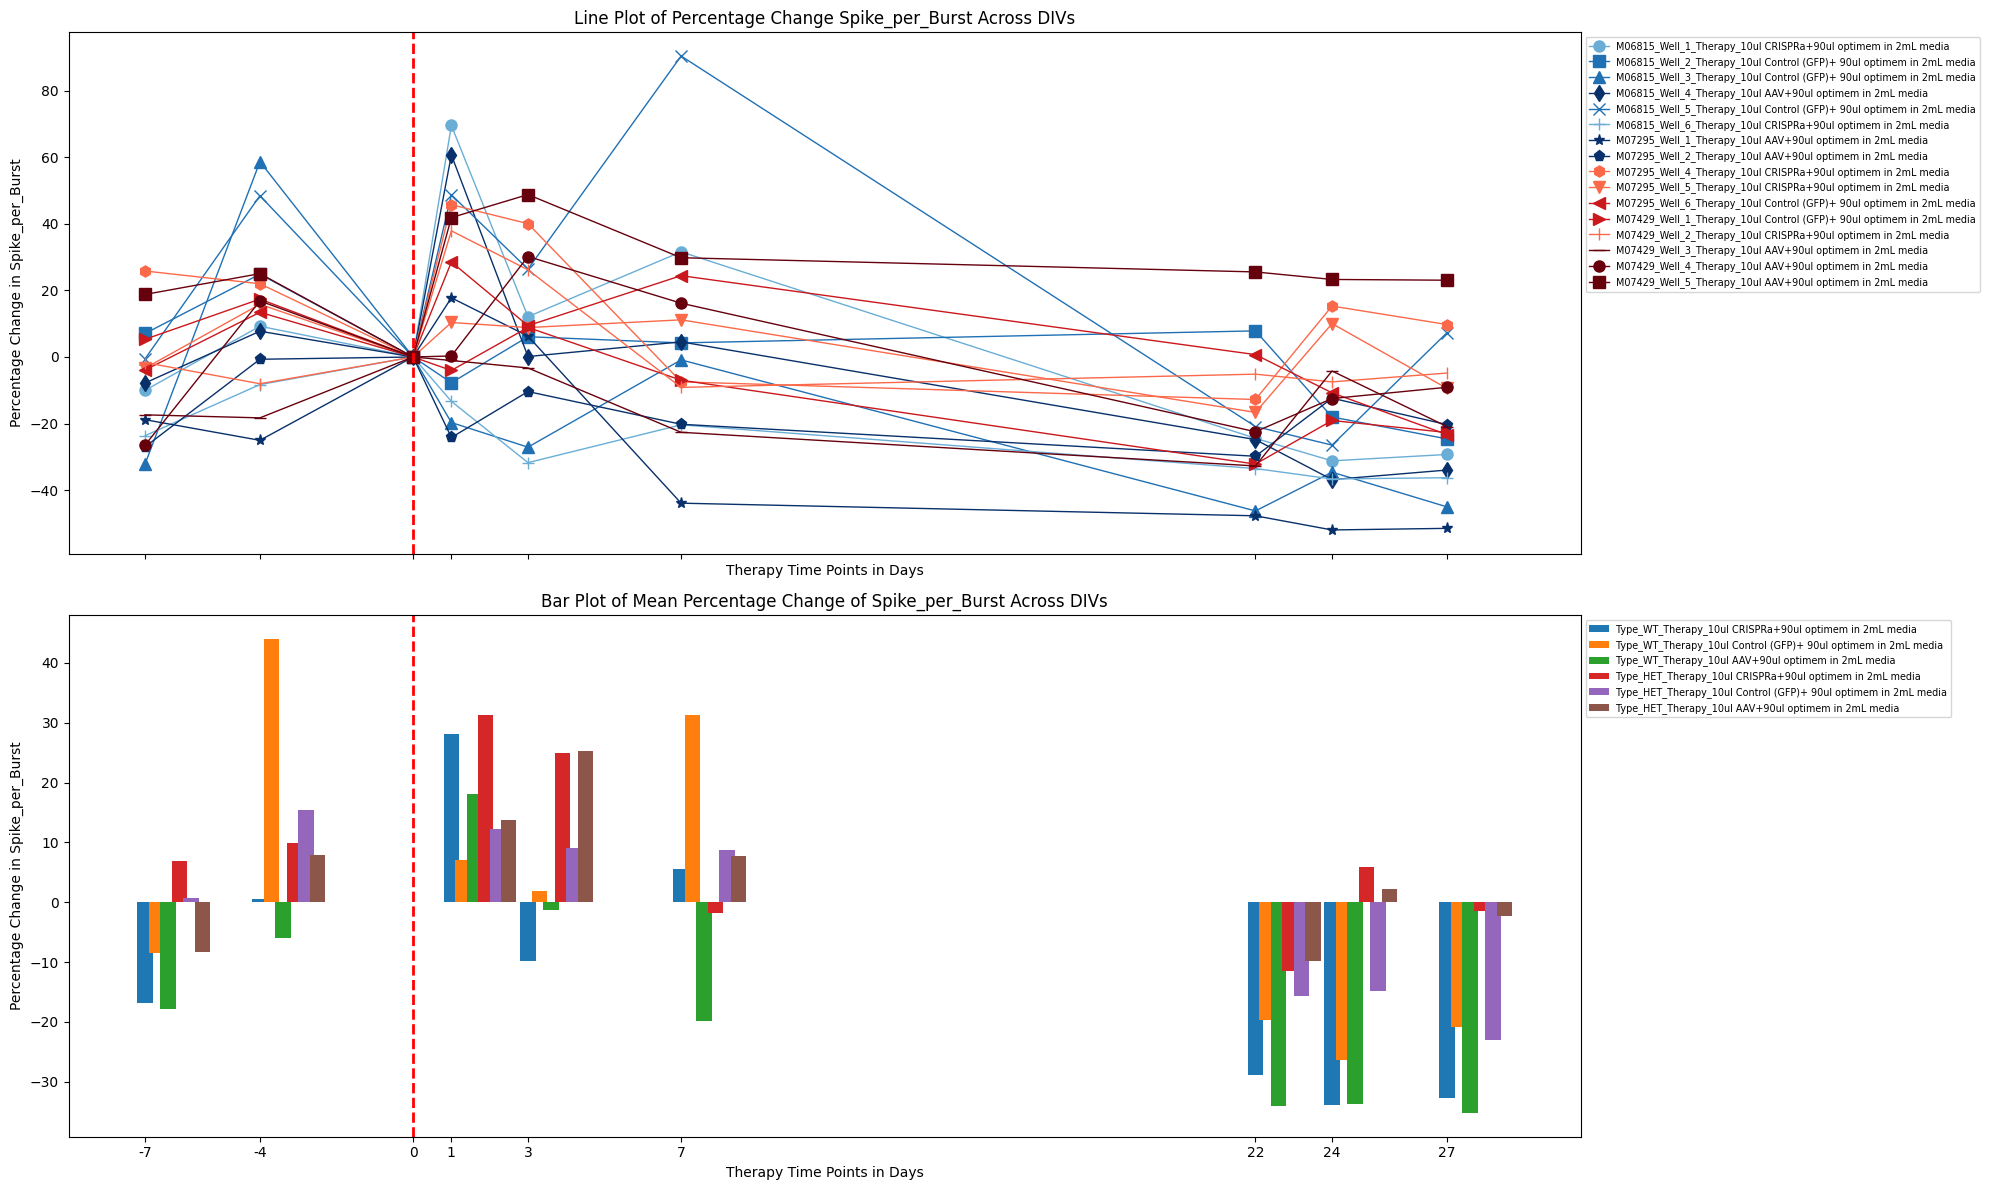

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example DataFrame loading step is skipped, ensure 'df' is properly initialized
output_types = ["Number_Bursts","Burst_Peak","IBI","Spike_per_Burst"]

# Assuming 'df' is your DataFrame
for output_type in output_types:
    # Adjusting DataFrame columns as per your existing code setup
    df['Chip_Well_Therapy_Key'] = df['Chip_ID'] + '_Well_' + df['Well'].astype(str) + '_Therapy_' + df['Therapy_type'].astype(str)
    df['Type_Therapy_Key'] = 'Type_' + df['Type'] + '_Therapy_' + df['Therapy_type'].astype(str)

    # Assuming 'Percentage_Change' calculation is already handled as per your setup
    # Calculate the baseline (DIV==0) value for each Chip_Well_Therapy_Key
    baseline_values = df[df['DIV'] == 0].groupby('Chip_Well_Therapy_Key')[output_type].first().to_dict()

    # Function to calculate percentage change
    def calculate_percentage_change(row):
        baseline = baseline_values.get(row['Chip_Well_Therapy_Key'], np.nan)
        if pd.isna(baseline) or baseline == 0:
            return np.nan
        return (row[output_type] - baseline) / baseline * 100

    # Apply the percentage change calculation
    df['Percentage_Change'] = df.apply(calculate_percentage_change, axis=1)
    # Define subplot grid and figure size
    fig, axs = plt.subplots(2, 1, figsize=(20, 12), sharex=True)  # Sharing X-axis (DIV)

    # First subplot for line plots
    for combo in df['Chip_Well_Therapy_Key'].unique():
        combo_data = df[df['Chip_Well_Therapy_Key'] == combo]
        if combo_data.empty:
            continue
        key_for_color = f"{combo_data['Type'].iloc[0]}_{combo_data['Therapy_type'].iloc[0]}"
        color = color_map.get(key_for_color, 'grey')
        
        # Assuming 'jitter' function is defined; if not, replace or remove jitter application
        # jittered_DIV = jitter(combo_data['DIV'], jitter_strength=0.2)
        # For simplicity, let's skip jitter here as it's not defined in your snippet
        axs[0].plot(combo_data['DIV'], combo_data['Percentage_Change'], label=f'{combo}',
                    color=color, marker=marker_map.get(combo, 'o'), linestyle='-', linewidth=1, markersize=8)

    # Second subplot for bar plots
    color_list = ['#1f77b4',  # Muted blue
                '#ff7f0e',  # Safety orange
                '#2ca02c',  # Cooked asparagus green
                '#d62728',  # Brick red
                '#9467bd',  # Muted purple
                '#8c564b']  # Chestnut brown
    unique_divs = sorted(df['DIV'].unique())
    legend_labels = set()
    for day in unique_divs:
        for idx, cbd in enumerate(df['Type_Therapy_Key'].unique()):
            cbddata = df[(df['Type_Therapy_Key'] == cbd) & (df['DIV'] == day)]
            if not cbddata.empty:
                #print(day)
                label = cbd if cbd not in legend_labels else "_nolegend_"
                axs[1].bar(day + (0.3 * idx), cbddata['Percentage_Change'].mean(), width=0.4,color =color_list[idx],label=label)
                legend_labels.add(cbd)
    # Customize subplots
    axs[0].set_title(f'Line Plot of Percentage Change {output_type} Across DIVs')
    axs[1].set_title(f'Bar Plot of Mean Percentage Change of {output_type} Across DIVs')

    for ax in axs:
        ax.set_xlabel('Therapy Time Points in Days')
        ax.set_ylabel(f'Percentage Change in {output_type}')
        ax.axvline(x=0, color='r', linestyle='--', linewidth=2)
        ax.legend(bbox_to_anchor=(1.0, 1), loc='upper left', fontsize='x-small', ncol=1)

    # Adjusting the x-axis ticks to reflect DIV values
    axs[1].set_xticks(unique_divs)
    axs[1].set_xticklabels(unique_divs)

    plt.tight_layout()
    plt.show()


In [70]:
df['Type_Therapy_Key'].unique()

array(['Type_WT_Therapy_10ul CRISPRa+90ul optimem in 2mL media',
       'Type_WT_Therapy_10ul Control (GFP)+ 90ul optimem in 2mL media',
       'Type_WT_Therapy_10ul AAV+90ul optimem in 2mL media',
       'Type_HET_Therapy_10ul CRISPRa+90ul optimem in 2mL media',
       'Type_HET_Therapy_10ul Control (GFP)+ 90ul optimem in 2mL media',
       'Type_HET_Therapy_10ul AAV+90ul optimem in 2mL media'],
      dtype=object)

In [46]:
df['Chip_Well_Therapy_Key'].unique()


array(['M06815_Well_1_Therapy_10ul CRISPRa+90ul optimem in 2mL media',
       'M06815_Well_2_Therapy_10ul Control (GFP)+ 90ul optimem in 2mL media',
       'M06815_Well_3_Therapy_10ul Control (GFP)+ 90ul optimem in 2mL media',
       'M06815_Well_4_Therapy_10ul AAV+90ul optimem in 2mL media',
       'M06815_Well_5_Therapy_10ul Control (GFP)+ 90ul optimem in 2mL media',
       'M06815_Well_6_Therapy_10ul CRISPRa+90ul optimem in 2mL media',
       'M07295_Well_1_Therapy_10ul AAV+90ul optimem in 2mL media',
       'M07295_Well_2_Therapy_10ul AAV+90ul optimem in 2mL media',
       'M07295_Well_4_Therapy_10ul CRISPRa+90ul optimem in 2mL media',
       'M07295_Well_5_Therapy_10ul CRISPRa+90ul optimem in 2mL media',
       'M07295_Well_6_Therapy_10ul Control (GFP)+ 90ul optimem in 2mL media',
       'M07429_Well_1_Therapy_10ul Control (GFP)+ 90ul optimem in 2mL media',
       'M07429_Well_2_Therapy_10ul CRISPRa+90ul optimem in 2mL media',
       'M07429_Well_3_Therapy_10ul AAV+90ul optimem in

In [41]:
df

Run_ID  DIV  Well NeuronType Type                  Time Chip_ID   
0       120   -7     1  ADNP2_WT2   WT  22-Nov-2023 11:09:55  M06815  \
1       120   -7     2  ADNP2_WT2   WT  22-Nov-2023 11:09:55  M06815   
2       120   -7     3  ADNP2_WT2   WT  22-Nov-2023 11:09:55  M06815   
3       120   -7     4  ADNP2_WT2   WT  22-Nov-2023 11:09:55  M06815   
4       120   -7     5  ADNP2_WT2   WT  22-Nov-2023 11:09:55  M06815   
..      ...  ...   ...        ...  ...                   ...     ...   
148      46   27     1  ADNP3_HET  HET  08-Jan-2024 11:42:17  M07429   
149      46   27     2  ADNP3_HET  HET  08-Jan-2024 11:42:17  M07429   
150      46   27     3  ADNP3_HET  HET  08-Jan-2024 11:42:17  M07429   
151      46   27     4  ADNP3_HET  HET  08-Jan-2024 11:42:17  M07429   
152      46   27     5  ADNP3_HET  HET  08-Jan-2024 11:42:17  M07429   

          IBI  Burst_Peak  Number_Bursts  Spike_per_Burst  Active_Electrodes   
0    2.290625    6.290534            129      3940.372093              82.12  \
1    1.864151    9.326187            160      5465.068750              90.32   
2    2.432787    8.947941            123      5607.487805              91.18   
3    2.838095    7.088772            106      4357.735849              77.97   
4    2.873077    7.782800            105      4595.800000              81.67   
..        ...         ...            ...              ...                ...   
148  2.889320    4.731934            104      3505.086538              59.85   
149  3.094737    6.360018             96      4590.614583              76.50   
150  2.869903    4.845260            104      4361.269231              67.53   
151  2.687273    5.175425            111      4062.216216              71.76   
152  2.846602    6.285936            104      4620.134615              71.95   

     Mean_FiringRate  Mean_SpikeAmplitude   
0           0.000000             0.000000  \
1           0.000000             0.000000   
2           0.000000             0.000000   
3           0.000000             0.000000   
4           0.000000             0.000000   
..               ...                  ...   
148         1.955899            51.865382   
149         2.566733            62.836347   
150         2.398931            58.153706   
151         2.053963            64.359346   
152         2.335741            68.863694   

                                      Therapy_type   
0           10ul CRISPRa+90ul optimem in 2mL media  \
1    10ul Control (GFP)+ 90ul optimem in 2mL media   
2    10ul Control (GFP)+ 90ul optimem in 2mL media   
3               10ul AAV+90ul optimem in 2mL media   
4    10ul Control (GFP)+ 90ul optimem in 2mL media   
..                                             ...   
148  10ul Control (GFP)+ 90ul optimem in 2mL media   
149         10ul CRISPRa+90ul optimem in 2mL media   
150             10ul AAV+90ul optimem in 2mL media   
151             10ul AAV+90ul optimem in 2mL media   
152             10ul AAV+90ul optimem in 2mL media   

                                 Chip_Well_Therapy_Key  Chip_Well_Key   
0    M06815_Well_1_Therapy_10ul CRISPRa+90ul optime...  M06815_Well_1  \
1    M06815_Well_2_Therapy_10ul Control (GFP)+ 90ul...  M06815_Well_2   
2    M06815_Well_3_Therapy_10ul Control (GFP)+ 90ul...  M06815_Well_3   
3    M06815_Well_4_Therapy_10ul AAV+90ul optimem in...  M06815_Well_4   
4    M06815_Well_5_Therapy_10ul Control (GFP)+ 90ul...  M06815_Well_5   
..                                                 ...            ...   
148  M07429_Well_1_Therapy_10ul Control (GFP)+ 90ul...  M07429_Well_1   
149  M07429_Well_2_Therapy_10ul CRISPRa+90ul optime...  M07429_Well_2   
150  M07429_Well_3_Therapy_10ul AAV+90ul optimem in...  M07429_Well_3   
151  M07429_Well_4_Therapy_10ul AAV+90ul optimem in...  M07429_Well_4   
152  M07429_Well_5_Therapy_10ul AAV+90ul optimem in...  M07429_Well_5   

              Phase  Percentage_Change  
0    Before Therapy          59.259259  
1    Before Therapy          4

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the data

# Create a combined key for unique identification of each Chip_ID and Well
df['Chip_Well_Key'] = df['Chip_ID'] + '_Well_' + df['Well'].astype(str)

# Plotting
# Adjust the figure size as needed

# Get unique combinations of Chip_ID and Well
unique_combinations = df['Chip_Well_Key'].unique()
color_map = dict(zip(unique_genotypes, colors))
# Define a list of markers
markers = ['o', 's', '^', 'd', 'x', '+', '*', 'p', 'h', 'v', '<', '>', '|', '_']

# Ensure there are enough markers for each combination; if not, cycle through them
if len(df['Chip_Well_Key'].unique()) > len(markers):
    markers *= int(np.ceil(len(df['Chip_Well_Key'].unique()) / len(markers)))

# Assign a marker to each Chip_Well_Key
marker_map = dict(zip(df['Chip_Well_Key'].unique(), markers))

# unique_divs = df['DIV'].unique()
# div_to_index = {div: i for i, div in enumerate(unique_divs)}
# df['DIV_Index'] = df['DIV'].apply(lambda x: div_to_index[x])
# df['Jittered_DIV_Index'] = jitter(df['DIV_Index'], jitter_strength=0.1)




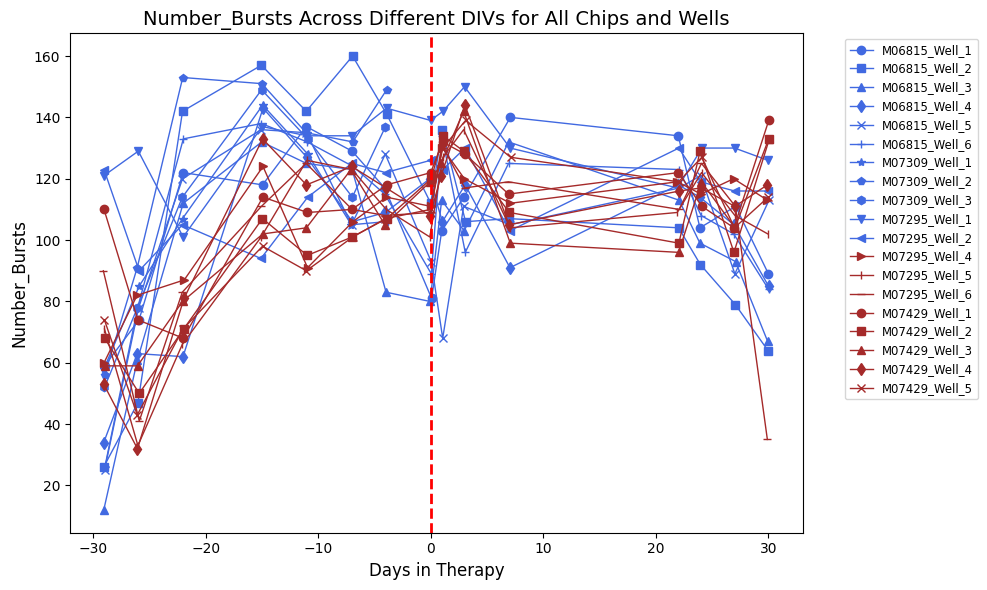

In [16]:
def jitter(x, jitter_strength=0.1):
    return x + np.random.uniform(-jitter_strength, jitter_strength, size=np.shape(x))
output_type='Number_Bursts'
fig, ax = plt.subplots(figsize=(10, 6))  
# Iterate over each unique combination to plot
for combo in unique_combinations:
    combo_data = df[df['Chip_Well_Key'] == combo]
    type_color = color_map[combo_data['Type'].iloc[0]]
    
    ax.plot(jitter(combo_data['DIV']), combo_data[output_type], label=combo,color=type_color, marker=marker_map[combo], linestyle='-', linewidth=1, markersize=6)

# Customizing the plot
ax.set_xlabel('Days in Therapy', fontsize=12)
ax.set_ylabel(f'{output_type}', fontsize=12)
ax.set_title(f'{output_type} Across Different DIVs for All Chips and Wells', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Move the legend outside the plot
ax.axvline(x=0, color='r', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

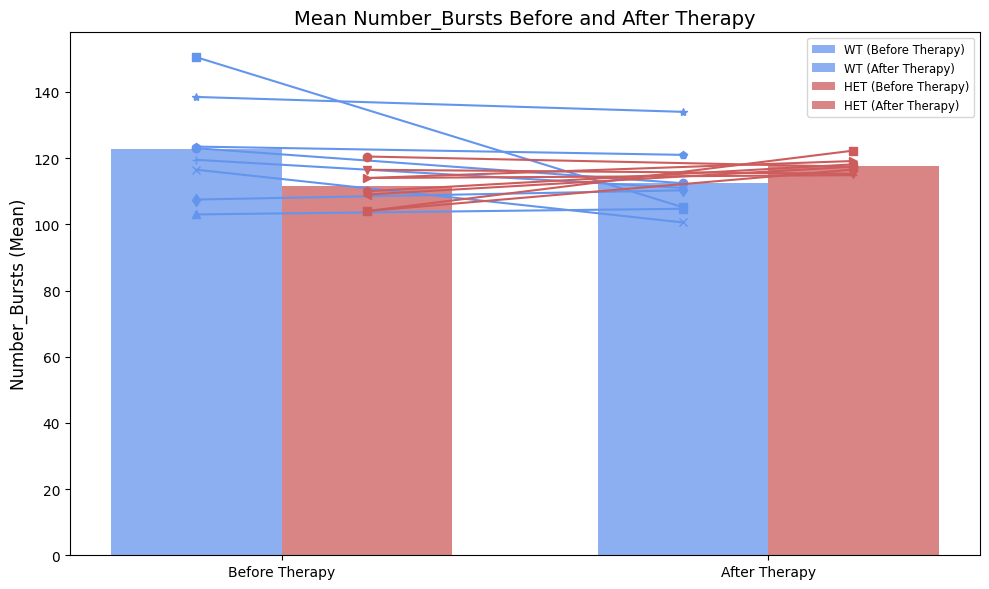

In [36]:
# Create a combined key for unique identification of each Chip_ID and Well
df['Chip_Well_Key'] = df['Chip_ID'] + '_Well_' + df['Well'].astype(str)

# Plotting
# Adjust the figure size as needed

# Get unique combinations of Chip_ID and Well
unique_combinations = df['Chip_Well_Key'].unique()
color_map = dict(zip(unique_genotypes, colors))
# Define a list of markers
markers = ['o', 's', '^', 'd', 'x', '+', '*', 'p', 'h', 'v', '<', '>', '|', '_']

# Ensure there are enough markers for each combination; if not, cycle through them
if len(df['Chip_Well_Key'].unique()) > len(markers):
    markers *= int(np.ceil(len(df['Chip_Well_Key'].unique()) / len(markers)))

# Assign a marker to each Chip_Well_Key
marker_map = dict(zip(df['Chip_Well_Key'].unique(), markers))

# Determine the phase relative to DIV 0
df['Phase'] = np.where(df['DIV'] < 0, 'Before Therapy', 'After Therapy')

# Segment data by Type and calculate mean for each Chip_Well_Key and Phase
grouped_means = df.groupby(['Type', 'Chip_Well_Key', 'Phase'])[output_type].mean().reset_index()

# Calculate overall mean for each type before and after DIV 0
overall_means_by_type = grouped_means.groupby(['Type', 'Phase'])[output_type].mean().reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

types = df['Type'].unique()
#colors = plt.cm.tab10(np.linspace(0, 1, len(types)))  # Using tab10 colormap for distinct colors
colors=['cornflowerblue','indianred']
type_color_map = dict(zip(types, colors))

# Plot bars for the overall means for each type
bar_width = 0.35  # Adjust as necessary
phase_positions = {'Before Therapy': 1, 'After Therapy': 2}  # Positional offsets for bars

# Plotting overall means as bars
for type_name, color in type_color_map.items():
    for phase, position in phase_positions.items():
        mean_value = overall_means_by_type[(overall_means_by_type['Type'] == type_name) & (overall_means_by_type['Phase'] == phase)][output_type].values
        if mean_value.size > 0:
            ax.bar(position + bar_width * list(types).index(type_name), mean_value, bar_width, label=f'{type_name} ({phase})', color=color, alpha=0.75)

# Plot lines connecting the same Chip_Well_Key before and after DIV 0 for each type
for type_name in types:
    type_group = grouped_means[grouped_means['Type'] == type_name]
    for chip in type_group['Chip_Well_Key'].unique():
        chip_data = type_group[type_group['Chip_Well_Key'] == chip]
        if chip_data['Phase'].nunique() == 2:  # Ensure data exists for both phases
            before_mean = chip_data[chip_data['Phase'] == 'Before Therapy'][output_type].values[0]
            after_mean = chip_data[chip_data['Phase'] == 'After Therapy'][output_type].values[0]
            ax.plot([1 + bar_width * list(types).index(type_name), 2 + bar_width * list(types).index(type_name)], [before_mean, after_mean], marker=marker_map[chip], color=type_color_map[type_name])

# Customizing the plot
ax.set_xticks([1 + bar_width * (len(types)-1) / 2, 2 + bar_width * (len(types)-1) / 2])
ax.set_xticklabels(['Before Therapy', 'After Therapy'])
ax.set_ylabel(f'{output_type} (Mean)', fontsize=12)
ax.set_title(f'Mean {output_type} Before and After Therapy', fontsize=14)
ax.legend(loc='best', fontsize='small')

plt.tight_layout()
plt.show()

In [ ]:
pd.set_option('display.max_rows',500)
df

Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT', 'HET']
[0, 1, 3, 7, 22, 24, 27]
Number of unique Genotypes: 2
['WT

/tmp/ipykernel_461812/3966627864.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


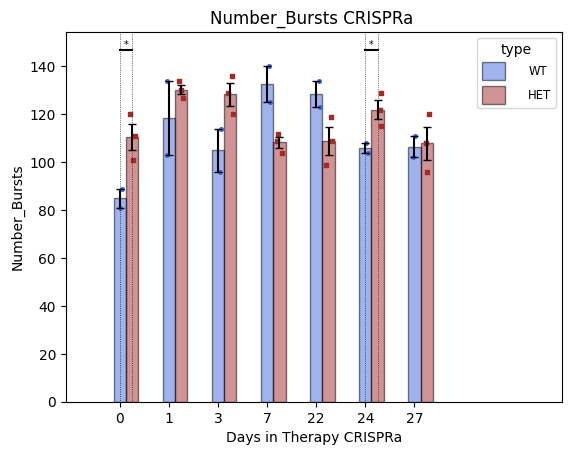

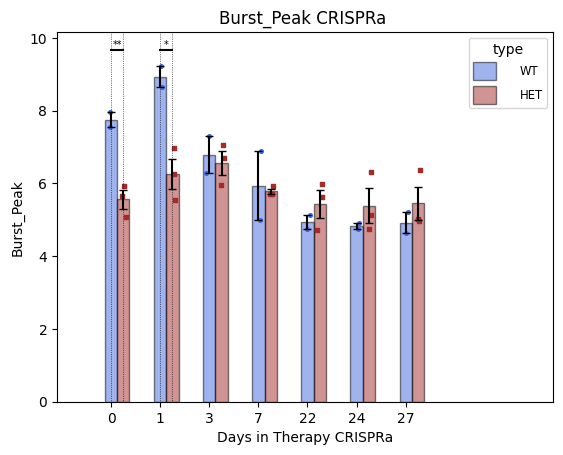

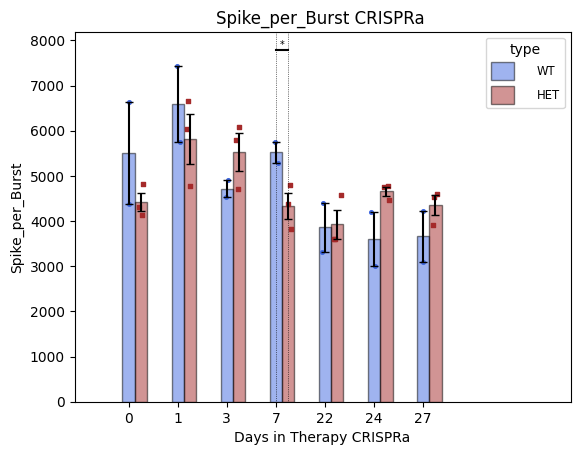

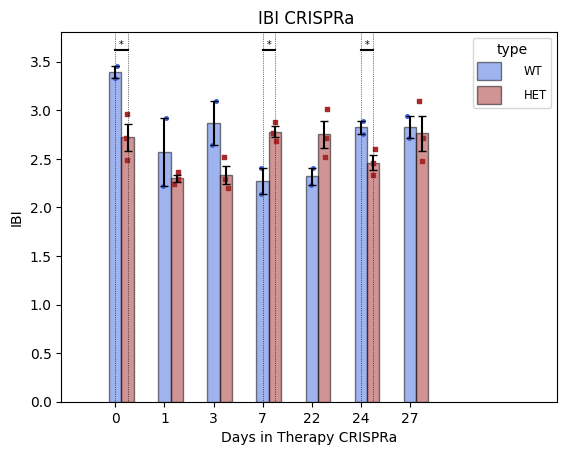

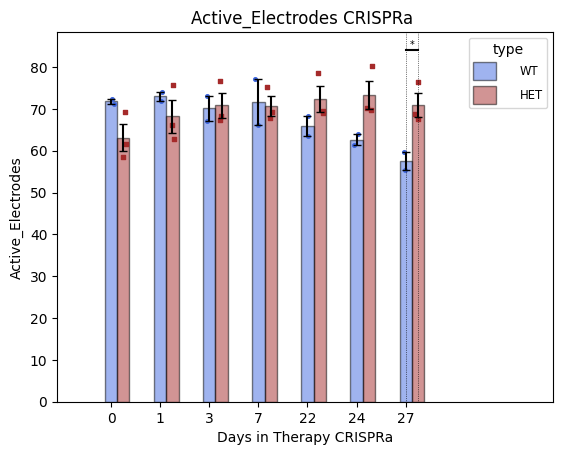

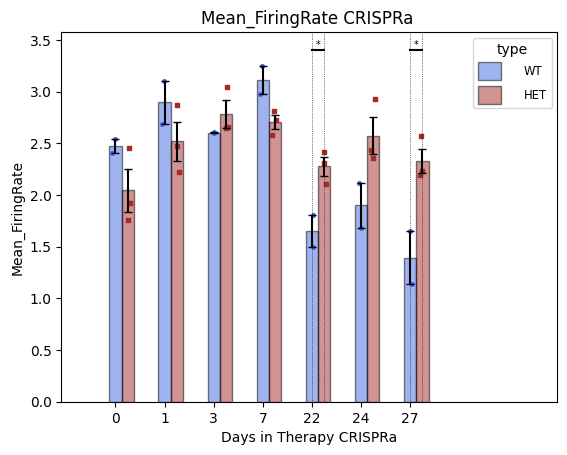

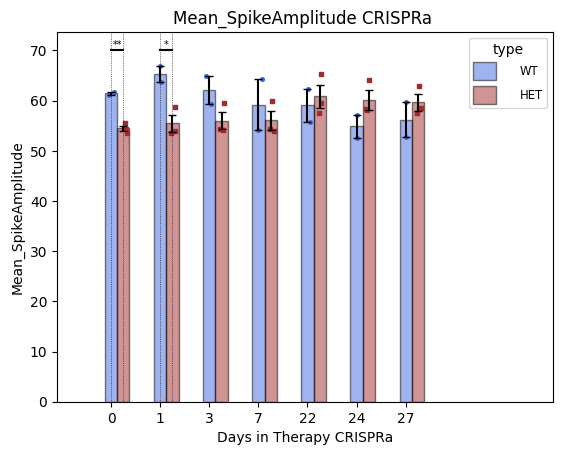

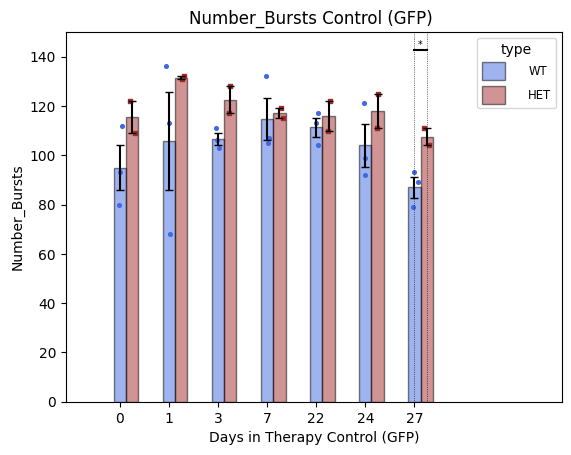

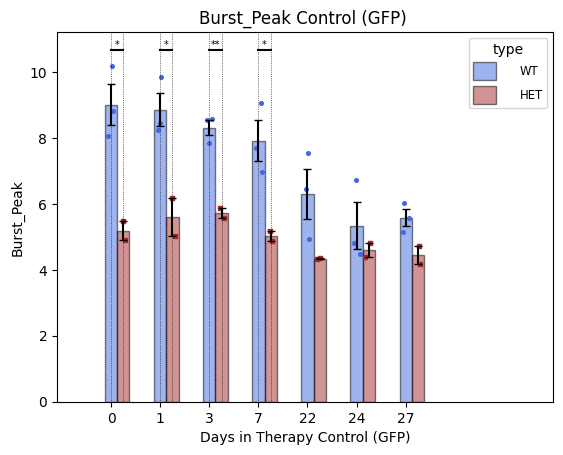

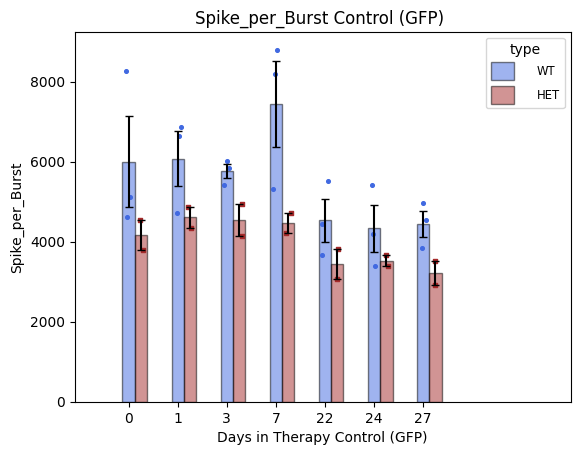

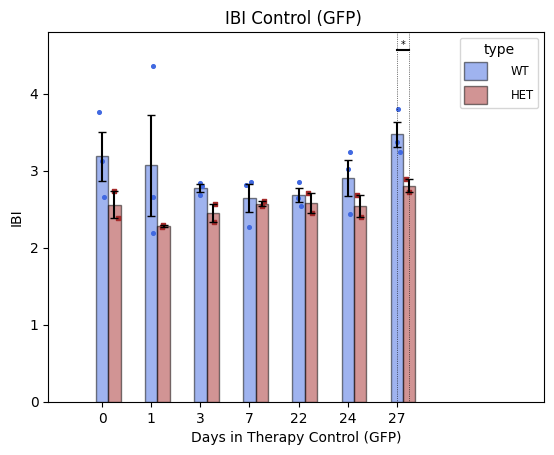

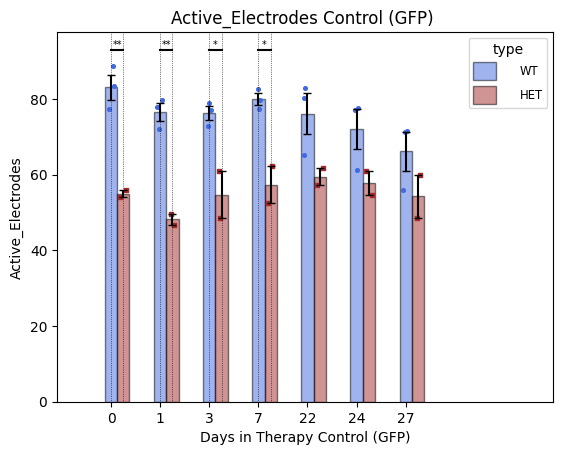

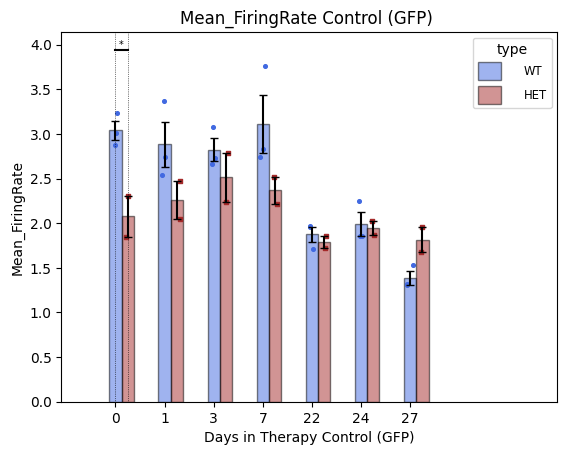

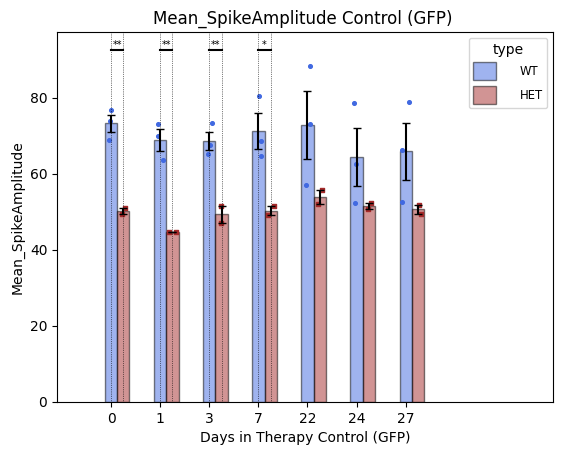

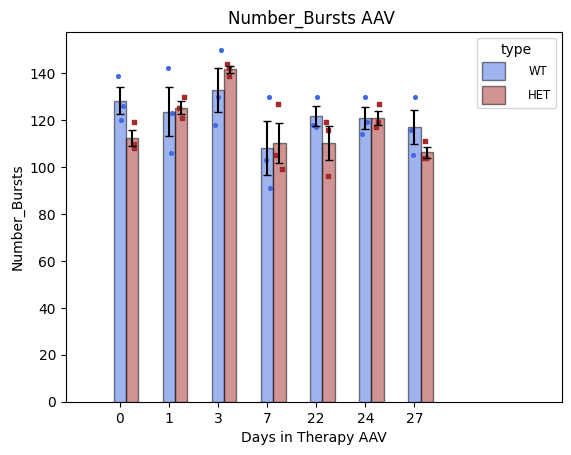

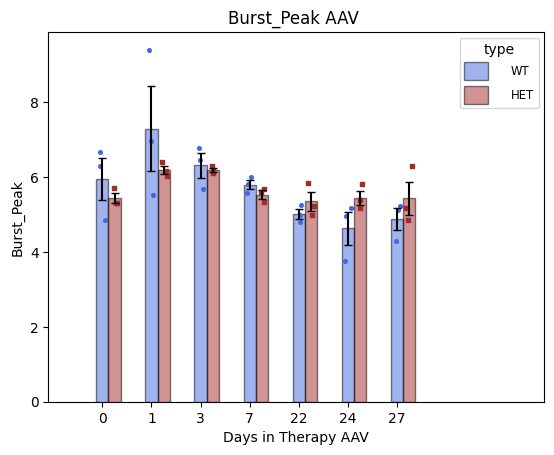

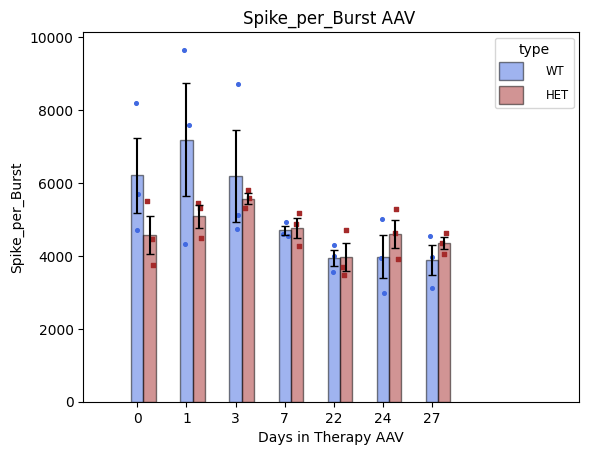

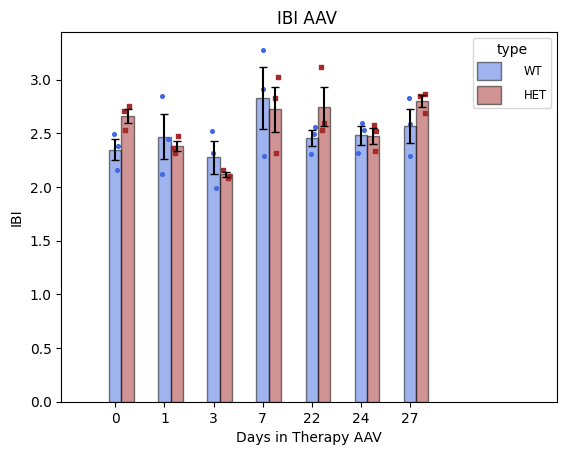

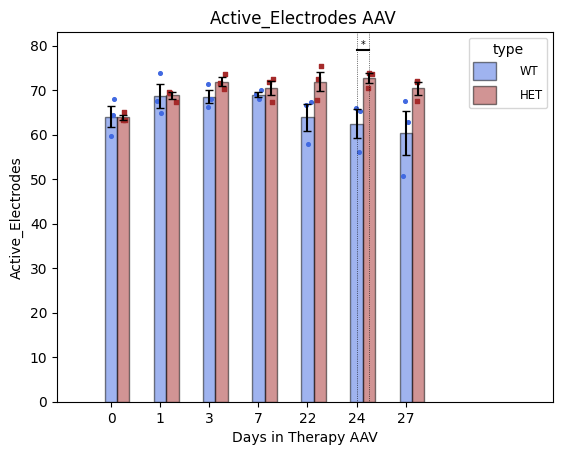

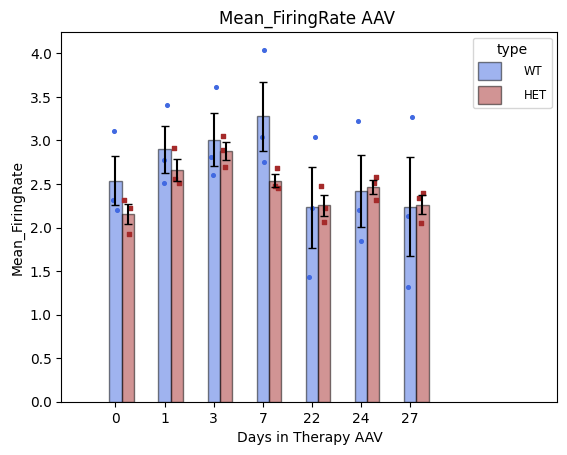

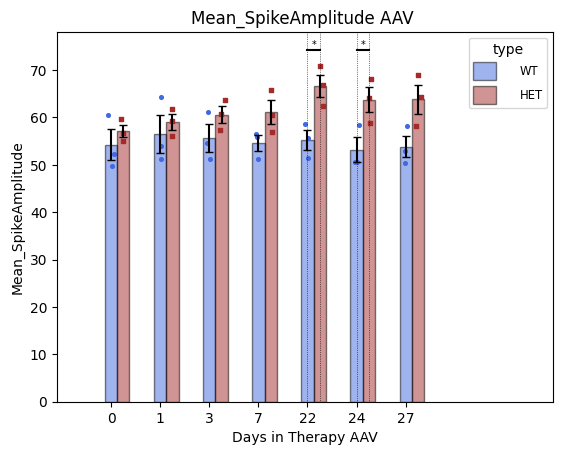

In [18]:
output_types =['Number_Bursts','Burst_Peak','Spike_per_Burst','IBI','Active_Electrodes','Mean_FiringRate','Mean_SpikeAmplitude']
#,'Mean_FiringRate','Mean_SpikeAmplitude']
#output_types=['Active_Electrodes']

for therapy_type in unique_therapy_types:
    for output_type in output_types:
        total_genotypes = len(unique_genotypes)
        #output_type='Number_Bursts'
        # Print the number of unique genotypes
        print(f"Number of unique Genotypes: {total_genotypes}")

        # Initialize output arrays for each unique genotype
        output_arrays = {genotype: [] for genotype in unique_genotypes}
        chip_arrays = {genotype: [] for genotype in unique_genotypes}
        well_arrays = {genotype: [] for genotype in unique_genotypes}
        print(unique_genotypes)
        # Fill data from data frame
        for i in div:
            for genotype in unique_genotypes:
                temp_df = df.loc[(df['DIV'] == i) &
                                (df['Type'].str.strip() == genotype)&
                                (df['Therapy_type'] == therapy_type)
                                ]
                output_arrays[genotype].append(np.array(temp_df[output_type]))
                chip_arrays[genotype].append(np.array(temp_df['Chip_ID']))
                well_arrays[genotype].append(np.array(temp_df['Well']))

        #pdb.set_trace()
        w = len(div)/32  # bar width
        gaplength = 1/(len(unique_genotypes)+2)
        # Create x-coordinates of bars
        x_day = [d for d in div]
        x_genotype = {genotype: [] for genotype in unique_genotypes}
        x_d = list(range(0, len(div)))

        # Assign x-coordinates for each genotype
        for i, genotype in enumerate(unique_genotypes):
            for x in x_d:
                
                x_genotype[genotype].append(x + (gaplength*i+1))


        # Initialize plot
        fig, ax = plt.subplots()
        # Generate a list of distinct colors based on the number of genotypes
        #colors = [plt.colormaps['Set1'](i) for i in np.linspace(0, 1, len(unique_genotypes))]# Using a colormap to generate colors
        #colors2 = [plt.colormaps['Set2'](i) for i in np.linspace(0, 1, len(unique_genotypes))]#
        # marker_shapes = ['^', 's', 'v', 'D', '+', 'x', '*', 'H', '8']
        # marker_chips={chip:marker_shapes[idx] for idx, chip in enumerate(track_chips)}
        # Plot data for each genotype
        mean_data_all ={}
        yerr_data_all = {}
        n_data_all={}
        #breakpoint()
        #pdb.set_trace()
        for i,genotype in enumerate(unique_genotypes):
            #breakpoint()
            y_data = output_arrays[genotype]
            chipy_data = chip_arrays[genotype]
            welly_data = well_arrays[genotype]
            #print("type: ",type(genotype))
            # Calculate statistics
            mean_data = [np.mean([n for n in yi if np.isfinite(n)]) for yi in y_data]
            yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1)/np.sqrt(np.size(yi)) for yi in y_data]
            n_data = [len(yi) for yi in y_data]
            # Store statistics in dictionaries
            mean_data_all[genotype] = mean_data
            yerr_data_all[genotype] = yerr_data
            n_data_all[genotype] = n_data
            # Save statistics to file
            output_file = f"intermediate_files/{output_type}_{genotype}_statistics.txt"
            with open(output_file, 'w') as file:
                file.write(f"{genotype} Statistics\n")
                file.write("Mean: " + ", ".join([str(m) for m in mean_data]) + "\n")
                file.write("SEM: " + ", ".join([str(sem) for sem in yerr_data]) + "\n")
                file.write("Sample Size (n): " + ", ".join([str(n_data)]) + "\n")
                
            # Plot bars
            #transparency value 
            alpha_value = 0.5
            ax.bar(x_genotype[genotype],
                height=mean_data,
                yerr=yerr_data,
                capsize=3,
                width=gaplength,
                color=colors[i],
                edgecolor='black',
                ecolor='black',
                alpha=alpha_value,label=genotype)
            #pdb.set_trace()
            # Plot scatter points
            #breakpoint()
            for j in range(len(x_genotype[genotype])):
                #pdb.set_trace()
                # ax.scatter(x_genotype[genotype][j] + np.zeros(y_data[j].size), y_data[j], s=20,color=colors2[i],marker=marker_chips[chipy_data[j]+str(welly_data[j])] if chipy_data[j]+str(welly_data[j]) in track_chips else 'o')
        # Concatenate corresponding elements from chipy_data[j] and welly_data[j]
                combined_data = [chip + str(well) for chip, well in zip(chipy_data[j], welly_data[j])]

                # # Check if the concatenated string is in track_chips, and set the marker accordingly
                # markers = [marker_chips.get(chipwell, 'o') for chipwell in combined_data]
                # #marker_chips[combined_data[0]] if combined_data[0] in track_chips else 'o'

                # Use the marker in the scatter plot
                jitter_amount=0.07
                for k in range(len(y_data[j])):
                    #pdb.set_trace()
                    ax.scatter(
                        x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount, 1),
                        y_data[j][k],
                        s=7,
                        color=colors[i],
                        marker=markers[i]
                            )


        # # Calculate maximum y-value for plotting significance
        # max_y = max([max(data) for data in output_arrays.values() if data.size > 0])
        # increment = max_y * 0.1  # Increment to adjust y-position for significance markers

        #Perform and plot t-tests between all pairs of genotype
        #pdb.set_trace()
        for i in range(len(x_d)):
            #maxim = max([max( output_arrays[genotype][i] )for genotype in unique_genotypes])
            maxim = max(max(array) for genotype_arrays in output_arrays.values() for array in genotype_arrays)
            count = 1
            p_values = []
            for j, genotype1 in enumerate(unique_genotypes):
                for k, genotype2 in enumerate(unique_genotypes):
                    if j < k:
                        #pdb.set_trace()
                        #print("mean_data_all",mean_data_all[genotype1])
                        #print("type:",type(genotype1))
                        mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                        mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                        #t_stat, p_value = stats.ttest_ind_from_stats(mean1, sem1, n1, mean2, sem2, n2)
                        sed = sqrt(sem1**2.0 + sem2**2.0)
                        t_stat = (mean1 - mean2) / sed
                        # degrees of freedom
                        degreef = n1+n2 - 2
                        alpha=0.05
                        # calculate the critical value
                        cv = stats.t.ppf(1.0 - alpha, degreef)
                        # calculate the p-vallue
                        p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                        p_values.append([mean1,sem1,mean2,sem2,p_value])

                        # Plot significance
                        #maxim = max(np.max(output_arrays[genotype1][i]), np.max(output_arrays[genotype2][i]))
                        x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                        
                        sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                        if not sign =='ns':
                            ax.plot([x1, x2], [maxim + 0.05*maxim*(count)] * 2, 'k', linewidth=1.5)
                            ax.text((x1 + x2) / 2, maxim +0.05*maxim*(count), sign, ha='center', va='bottom', fontsize=7)
                            ax.axvline(x1,color='black',linestyle=':',linewidth=0.5)
                            ax.axvline(x2,color='black',linestyle=':',linewidth=0.5)
                        count = count +1

                        with open(output_file, 'a') as file:
                                    file.write(f"P values:{p_values} \n")


        # Axis scaling and labeling
        #xmin = 0
        #xmax = (max(df['DIV']) - xmin)*1.25
        #ymin = 0
        #ymax = (max(df[output_type]) - ymin)*1.4
        #pdb.set_trace()
        plt.title(f"{output_type} {therapy_type} " )
        plt.xlabel(f'Days in Therapy {therapy_type}')
        plt.ylabel(output_type)
        #plt.xticks(list(map(lambda x: x + 1+(2*gaplength), x_d)), x_day)
        print(x_day)
        plt.xlim(-0.1,10)
        plt.xticks(list(map(lambda x: x + 1, x_d)),x_day)
        #ax.set_xticks(x_ticks)

        # Set the corresponding DIV labels for each tick position
        #ax.set_xticklabels(div)
        #plt.axis([xmin, len(div) + 1, ymin, ymax])
        
        plt.legend(title='type',loc='upper right', fontsize='small', handlelength=2, handletextpad=2, handleheight=2,bbox_to_anchor=(1.0, 1))
        import os 
        dirpath = f'/home/mmp/Documents/ADNP_aftertherapy_23jan/{therapy_type}'
        if not os.path.exists(dirpath):
             os.makedirs(dirpath)
        plt.savefig(f"{dirpath}/{output_type}.png",dpi=300,format='png')
        #ax.legend(labels = ['ADNP2 WT1','ADNP3 WT', 'ADNP2 HET1', 'ADNP3 HET'])

In [11]:
df

Run_ID  DIV                  Time  Chip_ID  Well  NeuronType   
0         1    6  25-Jul-2023 10:17:28    16744     1   WT cortex  \
1         3    6  25-Jul-2023 10:33:20    16795     1   WT cortex   
2         5    6  25-Jul-2023 10:54:18    16855     1   WT cortex   
3         7    6  25-Jul-2023 11:14:01    16793     1   WT cortex   
4         9    6  25-Jul-2023 11:27:26    16854     1   WT cortex   
..      ...  ...                   ...      ...   ...         ...   
131     422   30  18-Aug-2023 15:31:36    16715     1  HET cortex   
132     426   30  18-Aug-2023 15:56:56    19337     1  HET cortex   
133     430   30  18-Aug-2023 16:24:08    19390     1  HET cortex   
134     434   30  18-Aug-2023 16:48:22    16719     1  HET cortex   
135     438   30  18-Aug-2023 17:13:07    16828     1  HET cortex   

     Active_Electrodes  Mean_FiringRate  Mean_SpikeAmplitude  
0                36.76         1.362529            45.273888  
1                31.18         1.281659            45.126900  
2                23.42         1.210268            44.067656  
3                18.77         0.908286            54.791423  
4                23.24         1.057003            49.015701  
..                 ...              ...                  ...  
131              97.23         4.467846            95.776265  
132              90.38         3.413356            95.809582  
133              71.59         3.343372            87.121124  
134              93.56         3.064794            99.651887  
135              91.30         4.195542            95.380022  

[136 rows x 9 columns]

Number of unique Genotypes: 2
['WT cortex' 'HET cortex']
[6, 9, 13, 16, 20, 23, 27, 30]


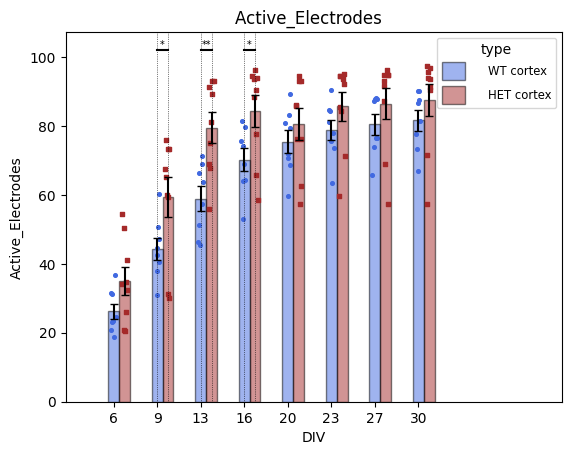

In [37]:
output_types =['Active_Electrodes']
for output_type in output_types:
    total_genotypes = len(unique_genotypes)
    #output_type='Number_Bursts'
    # Print the number of unique genotypes
    print(f"Number of unique Genotypes: {total_genotypes}")

    # Initialize output arrays for each unique genotype
    output_arrays = {genotype: [] for genotype in unique_genotypes}
    chip_arrays = {genotype: [] for genotype in unique_genotypes}
    well_arrays = {genotype: [] for genotype in unique_genotypes}
    print(unique_genotypes)
    # Fill data from data frame
    for i in div:
        for genotype in unique_genotypes:
            temp_df = df.loc[(df['DIV'] == i) &
                            (df['NeuronType'].str.strip() == genotype)
                            ]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
            chip_arrays[genotype].append(np.array(temp_df['Chip_ID']))
            well_arrays[genotype].append(np.array(temp_df['Well']))

    #pdb.set_trace()
    w = len(div)/32  # bar width
    gaplength = 1/(len(unique_genotypes)+2)
    # Create x-coordinates of bars
    x_day = [d for d in div]
    x_genotype = {genotype: [] for genotype in unique_genotypes}
    x_d = list(range(0, len(div)))

    # Assign x-coordinates for each genotype
    for i, genotype in enumerate(unique_genotypes):
        for x in x_d:
            
            x_genotype[genotype].append(x + (gaplength*i+1))


    # Initialize plot
    fig, ax = plt.subplots()
    # Generate a list of distinct colors based on the number of genotypes
    #colors = [plt.colormaps['Set1'](i) for i in np.linspace(0, 1, len(unique_genotypes))]# Using a colormap to generate colors
    #colors2 = [plt.colormaps['Set2'](i) for i in np.linspace(0, 1, len(unique_genotypes))]#
    # marker_shapes = ['^', 's', 'v', 'D', '+', 'x', '*', 'H', '8']
    # marker_chips={chip:marker_shapes[idx] for idx, chip in enumerate(track_chips)}
    # Plot data for each genotype
    mean_data_all ={}
    yerr_data_all = {}
    n_data_all={}
    #breakpoint()
    #pdb.set_trace()
    for i,genotype in enumerate(unique_genotypes):
        #breakpoint()
        y_data = output_arrays[genotype]
        chipy_data = chip_arrays[genotype]
        welly_data = well_arrays[genotype]
        #print("type: ",type(genotype))
        # Calculate statistics
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1)/np.sqrt(np.size(yi)) for yi in y_data]
        n_data = [len(yi) for yi in y_data]
        # Store statistics in dictionaries
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        # Save statistics to file
        output_file = f"intermediate_files/{output_type}_{genotype}_statistics.txt"
        with open(output_file, 'w') as file:
            file.write(f"{genotype} Statistics\n")
            file.write("Mean: " + ", ".join([str(m) for m in mean_data]) + "\n")
            file.write("SEM: " + ", ".join([str(sem) for sem in yerr_data]) + "\n")
            file.write("Sample Size (n): " + ", ".join([str(n_data)]) + "\n")
            
        # Plot bars
        #transparency value 
        alpha_value = 0.5
        ax.bar(x_genotype[genotype],
            height=mean_data,
            yerr=yerr_data,
            capsize=3,
            width=gaplength,
            color=colors[i],
            edgecolor='black',
            ecolor='black',
            alpha=alpha_value,label=genotype)
        #pdb.set_trace()
        # Plot scatter points
        #breakpoint()
        for j in range(len(x_genotype[genotype])):
            #pdb.set_trace()
            # ax.scatter(x_genotype[genotype][j] + np.zeros(y_data[j].size), y_data[j], s=20,color=colors2[i],marker=marker_chips[chipy_data[j]+str(welly_data[j])] if chipy_data[j]+str(welly_data[j]) in track_chips else 'o')
    # Concatenate corresponding elements from chipy_data[j] and welly_data[j]
            combined_data = [str(chip)+ str(well) for chip, well in zip(chipy_data[j], welly_data[j])]

            # # Check if the concatenated string is in track_chips, and set the marker accordingly
            # markers = [marker_chips.get(chipwell, 'o') for chipwell in combined_data]
            # #marker_chips[combined_data[0]] if combined_data[0] in track_chips else 'o'

            # Use the marker in the scatter plot
            jitter_amount=0.07
            for k in range(len(y_data[j])):
                #pdb.set_trace()
                ax.scatter(
                    x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount, 1),
                    y_data[j][k],
                    s=7,
                    color=colors[i],
                    marker=markers[i]
                        )


    # # Calculate maximum y-value for plotting significance
    # max_y = max([max(data) for data in output_arrays.values() if data.size > 0])
    # increment = max_y * 0.1  # Increment to adjust y-position for significance markers

    #Perform and plot t-tests between all pairs of genotype
    #pdb.set_trace()
    for i in range(len(x_d)):
        #maxim = max([max( output_arrays[genotype][i] )for genotype in unique_genotypes])
        maxim = max(max(array) for genotype_arrays in output_arrays.values() for array in genotype_arrays)
        count = 1
        p_values = []
        for j, genotype1 in enumerate(unique_genotypes):
            for k, genotype2 in enumerate(unique_genotypes):
                if j < k:
                    #pdb.set_trace()
                    #print("mean_data_all",mean_data_all[genotype1])
                    #print("type:",type(genotype1))
                    mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                    mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                    #t_stat, p_value = stats.ttest_ind_from_stats(mean1, sem1, n1, mean2, sem2, n2)
                    sed = sqrt(sem1**2.0 + sem2**2.0)
                    t_stat = (mean1 - mean2) / sed
                    # degrees of freedom
                    degreef = n1+n2 - 2
                    alpha=0.05
                    # calculate the critical value
                    cv = stats.t.ppf(1.0 - alpha, degreef)
                    # calculate the p-vallue
                    p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                    p_values.append([mean1,sem1,mean2,sem2,p_value])

                    # Plot significance
                    #maxim = max(np.max(output_arrays[genotype1][i]), np.max(output_arrays[genotype2][i]))
                    x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                    
                    sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                    if not sign =='ns':
                        ax.plot([x1, x2], [maxim + 0.05*maxim*(count)] * 2, 'k', linewidth=1.5)
                        ax.text((x1 + x2) / 2, maxim +0.05*maxim*(count), sign, ha='center', va='bottom', fontsize=7)
                        ax.axvline(x1,color='black',linestyle=':',linewidth=0.5)
                        ax.axvline(x2,color='black',linestyle=':',linewidth=0.5)
                    count = count +1

                    with open(output_file, 'a') as file:
                                file.write(f"P values:{p_values} \n")


    # Axis scaling and labeling
    #xmin = 0
    #xmax = (max(df['DIV']) - xmin)*1.25
    #ymin = 0
    #ymax = (max(df[output_type]) - ymin)*1.4
    #pdb.set_trace()
    plt.title(f"{output_type}  " )
    plt.xlabel(f'DIV')
    plt.ylabel(output_type)
    #plt.xticks(list(map(lambda x: x + 1+(2*gaplength), x_d)), x_day)
    print(x_day)
    plt.xlim(-0.1,11.3)
    plt.xticks(list(map(lambda x: x + 1, x_d)),x_day)
    #ax.set_xticks(x_ticks)

    # Set the corresponding DIV labels for each tick position
    #ax.set_xticklabels(div)
    #plt.axis([xmin, len(div) + 1, ymin, ymax])
    
    plt.legend(title='type',loc='upper right', fontsize='small', handlelength=2, handletextpad=2, handleheight=2,bbox_to_anchor=(1.0, 1))
    import os 
    dirpath = f'/home/mmp/Documents/SPTAN1/'
    if not os.path.exists(dirpath):
            os.makedirs(dirpath)
    plt.savefig(f"{dirpath}/{output_type}.svg",dpi=300,format='svg')

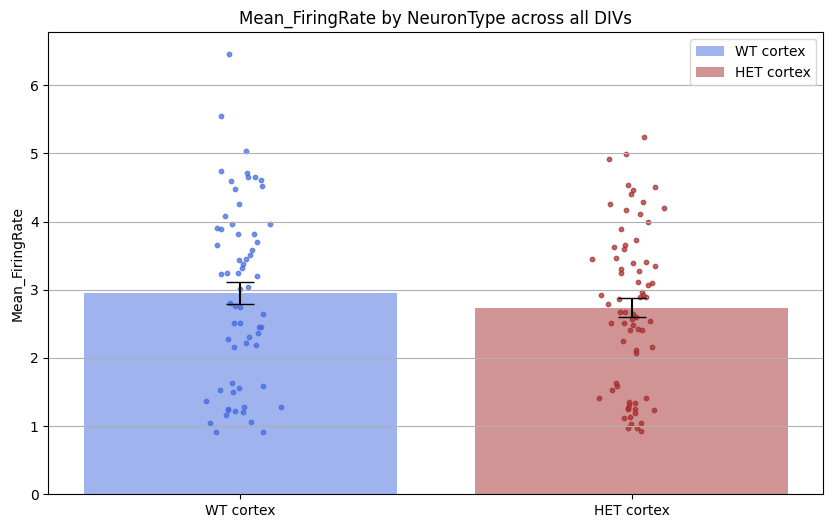

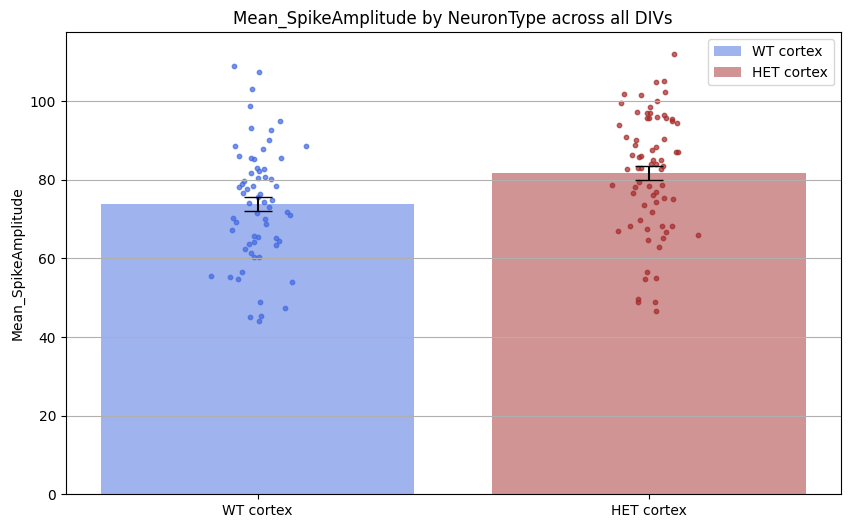

In [17]:
# Example DataFrame initialization is skipped

output_types = ['Mean_FiringRate', 'Mean_SpikeAmplitude']
unique_genotypes = df['NeuronType'].unique()
div = sorted(df['DIV'].unique())

for output_type in output_types:
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['royalblue','brown'] # Colors for each neuron type
    x_positions = np.arange(len(unique_genotypes))  # Bar positions

    for i, genotype in enumerate(unique_genotypes):
        genotype_data = df[df['NeuronType'] == genotype]
        means = genotype_data[output_type].mean()
        sems = genotype_data[output_type].sem()
        
        # Plotting the bar for the genotype
        ax.bar(x_positions[i], means, yerr=sems, align='center', alpha=0.5, ecolor='black', capsize=10, color=colors[i], label=genotype)
        
        # Scatter plot for all data points
        jittered_x = np.random.normal(x_positions[i], 0.04, size=genotype_data.shape[0])
        ax.scatter(jittered_x, genotype_data[output_type], color=colors[i], alpha=0.7, s=10)
    
    ax.set_ylabel(output_type)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(unique_genotypes)
    ax.set_title(f'{output_type} by NeuronType across all DIVs')
    ax.legend()
    ax.yaxis.grid(True)

    # Save the figure
    dirpath = f'/home/mmp/Documents/SPTAN1/'
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
    plt.savefig(os.path.join(dirpath, f"{output_type}_NeuronType.png"), dpi=300)
    plt.show()
    plt.close()

[0, 0.6]


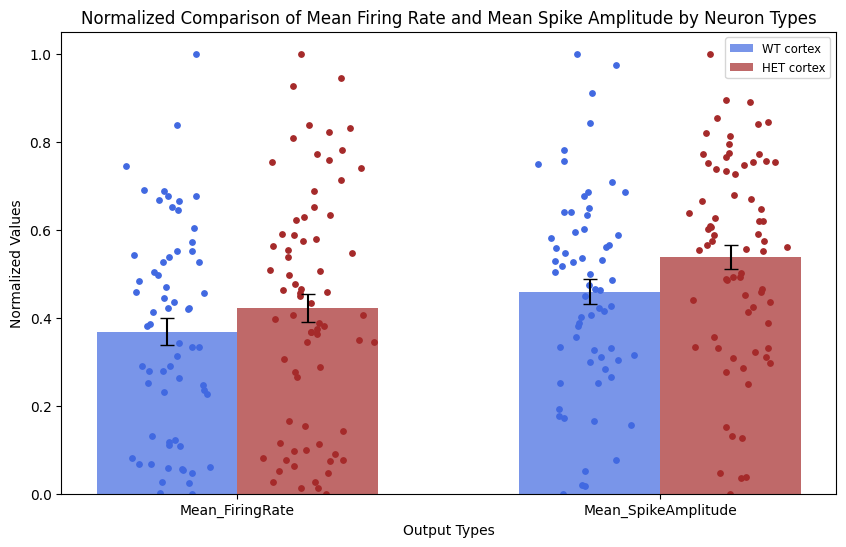

In [50]:
output_types = ['Mean_FiringRate', 'Mean_SpikeAmplitude']
# Function to normalize data to range [0, 1]
def normalize_data(series):
    return (series - series.min()) / (series.max() - series.min())

# Apply normalization for each output type
for output_type in output_types:
    df[output_type + '_Normalized'] = df.groupby('NeuronType')[output_type].transform(normalize_data)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['royalblue', 'brown']  # Assign colors for each neuron type
n_groups = len(output_types)
bar_width = 0.2  # Keep the bar width small to allow for closer grouping
index = [0 ,0.6] # Increase spacing between groups, but keep bars within a group closer
print(index)
# Adjust the index calculation for grouping
group_width = bar_width * len(unique_genotypes)  # Total width of a group of bars
offset = 1 - group_width + (2*bar_width)  # Offset to center bars around the group's x position

# Plot normalized data
for i, output_type in enumerate(output_types):
    normalized_output_type = output_type + '_Normalized'
    for j, genotype in enumerate(unique_genotypes):
        # Calculate mean and SEM for the normalized data
        genotype_data = df[df['NeuronType'] == genotype]
        mean = genotype_data[normalized_output_type].mean()
        sem = genotype_data[normalized_output_type].sem()
        
        # Calculate position for each bar, closer together within each group
        position = index[i] + (j * bar_width) 
        
        # Plot
        ax.bar(position, mean, yerr=sem, width=bar_width, color=colors[j], label=f"{genotype}" if i == 0 else "", capsize=5, alpha=0.7)
        
        # Scatter plot for all data points
        jittered_x = np.random.normal(position, 0.03, size=genotype_data.shape[0])
        ax.scatter(jittered_x, genotype_data[normalized_output_type], color=colors[j], alpha=1.0, s=15)

# Final touches
ax.set_xlabel('Output Types')
ax.set_ylabel('Normalized Values')
ax.set_title('Normalized Comparison of Mean Firing Rate and Mean Spike Amplitude by Neuron Types')
ax.set_xticks([0.1,0.7])
ax.set_xticklabels(output_types)
ax.legend(loc='upper right', fontsize='small')

# Save the figure
dirpath = '/home/mmp/Documents/SPTAN1/'  # Update this path as needed
if not os.path.exists(dirpath):
    os.makedirs(dirpath)
plt.savefig(os.path.join(dirpath, "barplots_NeuronType.svg"), dpi=300, format='svg')
plt.show()